<H1><center>New York City TLC Trip Taxi
<br>--------
<br><center>Data Preparation

## Latar Belakang


Salah satu jenis taxi yang beroperasi di New York City yaitu Street-hail Liveries atau yang juga dikenal sebagai green cabs atau taxi hijau ingin meningkatkan jumlah pengguna untuk jenis taxi hijau. Perusahaan telah melakukan pencatatan untuk semua riwayat perjalanan taxi hijau, dari pencatatan tersebut perusahaan ingin menentukan strategi bisnis yang akan dilakukan dalam upaya peningkatan jumlah pengguna taxi tersebut dilihat dari karakteristik pengguna taxi hijau.

## Pernyataan Masalah

Perusahaan ingin mengetahui **karakteristik pengguna taxi hijau yang sudah melakukan perjalanan**. Informasi tersebut akan membantu perusahaan untuk menentukan strategi bisnis dalam upaya peningkatan jumlah pengguna taxi hijau.

Sebagai seorang *data analyst*, kita akan mencoba menjawab pertanyaan berikut:

**Bagaimana karakteristik pengguna taxi hijau jika dilihat dari lokasi pickup dan dropoff, distribusi perjalanan setiap minggunya, jenis pembayaran, dan jenis tripnya**

## Asumsi dan Batasan Masalah:

- 1 trip mewakili 1 orang yang berbeda
- Tidak ada batasan umur orang yang menggunakan taksi
- Kenaikan atau penurunan populasi new york city tiap tahun tidak begitu signifikan
- Menggunakan data bulan Januari 2023

## Data:

Untuk menjawab permasalahan diatas, kita akan menganalisa data perjalanan taxi hijau di kota New York [di sini](https://drive.google.com/drive/folders/1NYHIL-RgVPW-HONz4pdzlcbIChF-c37N). Untuk mendukung analisis, kita juga memerlukan dataset yang menunjukan nama wilayah di kota new york berdasarkan lokasi ID [di sini](https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv), dan dataset yang menunjukan populasi untuk masing-masing wilayah di kota New York (Update: April 18, 2020) [di sini](https://data.beta.nyc/dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/7caac650-d082-4aea-9f9b-3681d568e8a5/download/nyc_zip_borough_neighborhoods_pop.csv)

In [100]:
# Import library python

import pandas as pd 
import numpy as np
import datetime
from datetime import timedelta
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import scipy.stats as stats
from scipy.stats import normaltest
from scipy.stats import spearmanr
from scipy.stats import ks_2samp # Uji KS untuk melihat distorsi sebelum dan sesudah handling outlier
import math
from sklearn.experimental import enable_iterative_imputer # Untuk melakukan imputasi
from sklearn.impute import IterativeImputer # Untuk melakukan imputasi

# Setting max column
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 35)

In [101]:
# Import seluruh dataset

# Import file csv utama (NYC TLC Trip Record.csv) (df)
df = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-2\data\\raw\\NYC TLC Trip Record.csv")

# Import file csv bantuan (taxi+_zone_lookup.csv) => mendapatkan nama wilayah dari LocationID (dfLoc)
dfLoc = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-2\data\external\\taxi+_zone_lookup.csv")

# Import file csv bantuan (nyc_zip_borough_neighborhoods_pop.csv) => mendapatkan jumlah populasi (2020) dari nama wilayah (dfPop)
dfPop = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-2\data\external\\nyc_zip_borough_neighborhoods_pop.csv")

C:\Users\Computer\AppData\Local\Temp\ipykernel_11240\504722045.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-2\data\\raw\\NYC TLC Trip Record.csv")


### Function yang digunakan 

Dalam memudahkan mengerjakan project, maka dibuatlah sejumlah fungsi yang dapat dipanggil ketika dibutuhkan.

In [102]:
# Fungsi mengecek karakteristik data

def checkData(x):
    return pd.DataFrame(
        {
        'feature': x.columns.values,
        'data_type': x.dtypes.values,
        'total_row': x.isna().count().values,
        'total_null': x.isna().sum().values,
        '%null_value': x.isna().mean().values * 100,
        'n_unique': x.nunique().values,
        'sample_unique': [x[col].unique() for col in x.columns]
        }
    )

## 1. Analisis singkat untuk setiap dataset yang digunakan

### 1.1. Cek dataset NYC TLC Trip Record (`df`) secara singkat

In [103]:
# Tampilkan summary untuk dataset NYC TLC Trip Record (df)

checkData(df)

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,VendorID,int64,68211,0,0.000000,2,"[2, 1]"
1,lpep_pickup_datetime,object,68211,0,0.000000,66575,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
2,lpep_dropoff_datetime,object,68211,0,0.000000,66519,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 202..."
3,store_and_fwd_flag,object,68211,4324,6.339154,2,"[N, Y, nan]"
4,RatecodeID,float64,68211,4324,6.339154,6,"[1.0, 5.0, 4.0, 3.0, 2.0, 99.0, nan]"
5,PULocationID,int64,68211,0,0.000000,226,"[166, 24, 223, 41, 181, 255, 75, 66, 195, 83, ..."
6,DOLocationID,int64,68211,0,0.000000,249,"[143, 43, 179, 238, 74, 262, 45, 75, 166, 140,..."
7,passenger_count,float64,68211,4324,6.339154,10,"[1.0, 2.0, 4.0, 3.0, 6.0, 5.0, 0.0, 7.0, 9.0, ..."
8,trip_distance,float64,68211,0,0.000000,1870,"[2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1..."
9,fare_amount,float64,68211,0,0.000000,2553,"[14.9, 10.7, 7.2, 6.5, 6.0, 17.7, 19.1, 14.2, ..."


**Insight:**
* Terdapat (`n=68211`) baris dan `20` kolom pada dataset NYC TLC Trip Record, yaitu:
    * **`VendorID`**: Nomor ID dari provider teknologi yang menyediakan rekam data perjalanan taxi
    * **`lpep_pickup_datetime`**: Waktu pickup ketika taximeter mulai dijalankan
    * **`lpep_dropoff_datetime`**: Waktu drop-off ketika taximeter dihentikan
    * **`store_and_fwd_flag`**: Keterangan jika driver terhubung ke server saat perjalanan (Y) atau tidak (N)
    * **`RatecodeID`**: Jenis tarif dasar berdasarkan rute perjalanan, bergantung pada lokasi tujuan/drop-off
    * **`PULocationID`**: Nomor ID dari lokasi pick-up
    * **`DOLocationID`**: Nomor ID dari lokasi drop-off
    * **`passenger_count`**: Jumlah penumpang untuk setiap trip
    * **`trip_distance`**: Jarak tempuh perjalanan dalam mil
    * **`fare_amount`**: Tarif perjalanan berdasarkan jarak tempuh dan durasi perjalanan
    * **`extra`**: Tarif tambahan lain-lain seperti tarif rush hour atau overnight
    * **`mta_tax`**: Tarif pajak
    * **`tip_amount`**: Tip yang dibayarkan secara credit card
    * **`tolls_amount`**: Tarif tambahan ketika melalui jalan tol
    * **`ehail_fee`**: Keterangan atribut tidak tersedia pada referensi, tetapi diasumsikan sebagai tarif tambahan ketika taxi dipesan melalui aplikasi
    * **`improvement_surcharge`**: Tarif tambahan untuk perbaikan/maintenance layanan
    * **`total_amount`**: Total yang dibayar penumpang di luar tip secara cash
    * **`payment_type`**: Metode pembayaran
    * **`trip_type`**: Jenis perjalanan berupa street-hail (dipesan langsung di jalan) dan dispatch (dipesan melalui panggilan ke pangkalan)
    * **`congestion_surcharge`**: Tarif tambahan ketika ada kemacetan. Jika terjadi kemacetan (2.75), jika tidak (0.00)

* Dalam analisis pertama kita akan melakukan:
    1. Merubah tipedata yang bermasalah pada dataset NYC TLC Trip Record
    2. Mengganti susunan kolom agar lebih mudah dalam pengolahan data
    3. Menambah kolom baru trip_duration_minute dan avg_speed
    4. Menghapus kolom yang tidak digunakan dalam analisis
    5. Mengganti nilai (2.50, -2.75) -> 2.75 di "congestion_surcharge"
    6. Menghapus nilai (264, 265) pada kolom "PULocationID", dan "DOLocationID". Karena nilai tersebut adalah "`unknown`" dan kita tidak dapat menyimpulkan lokasi pickup dan dropoff dari trip tersebut. #Insight ini didapat dari insight pada dataset LocationID (dfLoc)

In [104]:
# 1. Merubah tipe data

df = df.astype({
    "lpep_pickup_datetime": "datetime64[s]",
    "lpep_dropoff_datetime": "datetime64[s]",
    "VendorID": "str",
    "RatecodeID": "str",
    "PULocationID": "str",
    "DOLocationID": "str",
    "passenger_count": "str",
    "payment_type": "str",
    "trip_type": "str"
})

# Convert "nan" value menjadi nan missing value
df.replace("nan", np.nan, regex=True, inplace=True)

In [105]:
# 2. Mengganti susunan kolom

df = df[["VendorID", "lpep_pickup_datetime", "lpep_dropoff_datetime",
       "store_and_fwd_flag", "RatecodeID", "PULocationID", "DOLocationID",
       "passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax",
       "tip_amount", "tolls_amount", "ehail_fee", "improvement_surcharge",
       "congestion_surcharge", "total_amount", "payment_type", "trip_type"]]

In [106]:
# 3. Menambah kolom baru

# Buat kolom baru "trip_duration_minute" = selisih antara "lpep_dropoff_datetime" - "lpep_pickup_datetime"
diff_dur = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
df.insert(3, "trip_duration_minute", (diff_dur/np.timedelta64(1, 'm')).astype('float').round(2))

# Buat kolom baru "avg_speed_MPH" = "trip_distance" / "trip_duration_minute"
# condition if: ("trip_distance" & "trip_duration_minute") == 0 | "trip_duration_minute" == 0, "trip_duration_minute" == 0, else: ("trip_distance" / "trip_duration_minute")
df.insert(4, "avg_speed_MPH", np.where( ((df["trip_distance"] == 0) & (df["trip_duration_minute"] == 0 )) | (df["trip_duration_minute"] == 0 ), 0, (df["trip_distance"] / (df["trip_duration_minute"] / 60)).round(2)))

In [107]:
# 4. Menghapus kolom

# Drop kolom "store_and_fwd_flag" dan "ehail_fee" pada file "NYC TLC Trip Record". Kolom tersebut tidak digunakan dalam analisis data untuk selanjutnya
df.drop(columns=["ehail_fee", "store_and_fwd_flag"], inplace=True)

In [108]:
# 5. Mengganti nilai pada kolom "congestion_surcharge"

df.congestion_surcharge.replace([2.5, -2.75], 2.75, inplace=True)

In [109]:
# 6. Menghapus nilai (264, 265) pada kolom "PULocationID", dan "DOLocationID" (n=712)

index_drop = df[(df["PULocationID"] == "264") |
                (df["PULocationID"] == "265") |
                (df["DOLocationID"] == "264") |
                (df["DOLocationID"] == "265")].index

df.drop(index_drop, inplace=True)

In [110]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,11.02,14.05,1.0,166,143,1.0,2.58,14.90,1.0,0.5,4.03,0.0,1.0,2.75,24.18,1.0,1.0
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,6.77,16.04,1.0,24,43,1.0,1.81,10.70,1.0,0.5,2.64,0.0,1.0,0.00,15.84,1.0,1.0
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,6.33,0.00,1.0,223,179,1.0,0.00,7.20,1.0,0.5,1.94,0.0,1.0,0.00,11.64,1.0,1.0
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,5.82,13.40,1.0,41,238,1.0,1.30,6.50,0.5,1.5,1.70,0.0,1.0,0.00,10.20,1.0,1.0
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,5.97,11.06,1.0,41,74,1.0,1.10,6.00,0.5,1.5,0.00,0.0,1.0,0.00,8.00,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,13.00,18788.40,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,1.0,NaN,16.70,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,8.00,16.05,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,1.0,NaN,5.41,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,16.00,12.90,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,1.0,NaN,21.04,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,18.00,10.10,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,1.0,NaN,19.18,NaN,NaN


Saat ini pada dataframe (`df`) Jumlah baris (`n=67499`), dan kolom (`20`)

### 1.2. Cek dataset locationID (`dfLoc`) secara singkat

In [111]:
# Tampilkan summary untuk dataset locationID (dfLoc)

checkData(dfLoc)

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,LocationID,int64,265,0,0.000000,265,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,Borough,object,265,0,0.000000,7,"[EWR, Queens, Bronx, Manhattan, Staten Island,..."
2,Zone,object,265,1,0.377358,261,"[Newark Airport, Jamaica Bay, Allerton/Pelham ..."
3,service_zone,object,265,2,0.754717,4,"[EWR, Boro Zone, Yellow Zone, Airports, nan]"


**Insight:**
* Terdapat 4 kolom pada dataset LocationID, yaitu:
    * **`LocationID`**: Nomor ID dari lokasi yang berada di wilayah New York City
    * **`Borough`**: Wilayah bagian di New York City
    * **`Zone`**: Daerah dari Wilayah bagian di New York City 
    * **`service_zone`**: Zona layanan taxi yang tersedia

* Dalam analisis pertama kita akan melakukan:
    1. Merubah tipedata yang bermasalah pada dataset LocationID
    2. Menghapus nilai (264, 265) pada kolom "LocationID". Karena nilai tersebut adalah "`unknown`" dan kita tidak dapat menyimpulkan lokasi pickup dan dropoff dari trip tersebut. #Hal yang sama juga dilakukan untuk dataset NYC TLC Trip Record (df) sebelumnya.

In [112]:
# 1. Merubah tipedata

dfLoc["LocationID"] = dfLoc["LocationID"].astype(str)

In [113]:
# 2. Menghapus nilai (264, 265) pada kolom "LocationID" (n=2)

index_drop_locationID = dfLoc[(dfLoc["LocationID"] == "264") |
                       (dfLoc["LocationID"] == "265")].index
dfLoc.drop(index_drop_locationID , inplace=True)

In [114]:
dfLoc

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
258,259,Bronx,Woodlawn/Wakefield,Boro Zone
259,260,Queens,Woodside,Boro Zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone


Saat ini pada dataframe (`dfLoc`) Jumlah baris (`n=263`), dan kolom (`4`)

### 1.3. Cek dataset Population (`dfPop`) secara singkat

In [115]:
# Tampilkan summary untuk dataset population New York (dfPop)

checkData(dfPop)

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,zip,int64,177,0,0.0,177,"[10001, 10002, 10003, 10004, 10005, 10006, 100..."
1,borough,object,177,0,0.0,5,"[Manhattan, Staten Island, Bronx, Queens, Broo..."
2,post_office,object,177,0,0.0,44,"[New York, NY, Staten Island, NY, Bronx, NY, G..."
3,neighborhood,object,177,0,0.0,45,"[Chelsea and Clinton, Lower East Side, Lower M..."
4,population,int64,177,0,0.0,176,"[21102, 81410, 56024, 3089, 7135, 3011, 6988, ..."
5,density,int64,177,0,0.0,177,"[33959, 92573, 97188, 5519, 97048, 32796, 4275..."


**Insight:**
* Terdapat 6 kolom pada dataset NYC TLC Trip Record, yaitu:
    * **`zip`**: Nomor kode pos wilayah New York City
    * **`borough`**: Wilayah bagian di New York City
    * **`post_office`**: Kantor pos di wilayah New York City 
    * **`neighborhood`**: Pembagian wilayah New York City
    * **`population`**: Populasi penduduk untuk setiap zip
    * **`density`**: Kepadatan penduduk untuk setiap zip

* Dalam analisis pertama kita akan melakukan:
    1. Menghapus kolom yang tidak digunakan dalam analisis. (zip, post_office, neighborhood)
    2. Mengelompokan jumlah populasi dan rata-rata density berdasarkan kolom borough

In [116]:
# 1. Menghapus kolom "zip", "post_office", "neighborhood"

dfPop.drop(columns=["zip", "post_office", "neighborhood"], inplace=True)


In [117]:
# 2. Mengelompokan populasi dan density

dfPop = dfPop.groupby("borough").agg({"population": "sum", "density": "mean"}).reset_index()

In [118]:
dfPop

,borough,population,density
0,Bronx,1382480,43097.640000
1,Brooklyn,2504700,41710.864865
2,Manhattan,1575590,75492.477273
3,Queens,2233270,26896.305085
4,Staten Island,468730,9763.916667


Saat ini pada dataframe (`dfPop`) Jumlah baris (`n=5`), dan kolom (`3`)

### 1.4. Menggabungkan dataset

Untuk memudahkan dalam proses pengolahan data, maka untuk setiap dataset yang ada akan digabungkan kedalam 1 dataframe dengan nama (df).
1. Gabungkan dataset NYC TLC Trip Record (df) dengan dataset locationID (dfLoc) dengan cara merge, how=left, gabungkan LocationID (dfLoc) dengan PULocationID (df) dan DOLocationID (df)
2. Gabungkan dataset NYC TLC Trip Record (df) dan dataset locationID (dfLoc) yang sudah digabungkan (df) dengan dataset Population (dfPop) dengan cara merge, how=left, gabungkan Borough (df) dengan PU_Borough (df) dan DO_Borough (df)

In [119]:
# 1. Gabung dataset NYC TLC Trip Record (df) dengan dataset LocationID (dfLoc)

df = df.merge(dfLoc.set_index("LocationID"), left_on="PULocationID", how="left", right_index=True)
df.rename(columns={"Borough": "PU_Borough",
                   "Zone": "PU_Zone",
                   "service_zone": "PU_Service_Zone"}, inplace=True)

df = df.merge(dfLoc.set_index("LocationID"), left_on="DOLocationID", how="left", right_index=True)
df.rename(columns={"Borough": "DO_Borough",
                   "Zone": "DO_Zone",
                   "service_zone": "DO_Service_Zone"}, inplace=True)

In [120]:
# 2. Gabung dataset yang sudah digabungkan (df) dengan dataset Population (dfPop)

df = df.merge(dfPop.set_index("borough"), left_on="PU_Borough", how="left", right_index=True)
df.rename(columns={"population": "PU_population",
                   "density": "PU_density"}, inplace=True)

df = df.merge(dfPop.set_index("borough"), left_on="DO_Borough", how="left", right_index=True)
df.rename(columns={"population": "DO_population",
                   "density": "DO_density"}, inplace=True)

In [121]:
# Cek karakteristik data kembali

# reset index
df = df.reset_index()
df = df.drop(columns="index")

# cek karakteristik dataframe
checkData(df)

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,VendorID,object,67499,0,0.000000,2,"[2, 1]"
1,lpep_pickup_datetime,datetime64[s],67499,0,0.000000,65903,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
2,lpep_dropoff_datetime,datetime64[s],67499,0,0.000000,65838,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 202..."
3,trip_duration_minute,float64,67499,0,0.000000,3605,"[11.02, 6.77, 6.33, 5.82, 5.97, 17.55, 17.42, ..."
4,avg_speed_MPH,float64,67499,0,0.000000,3568,"[14.05, 16.04, 0.0, 13.4, 11.06, 9.5, 13.09, 8..."
5,RatecodeID,object,67499,4304,6.376391,6,"[1.0, 5.0, 3.0, 2.0, 99.0, 4.0, nan]"
6,PULocationID,object,67499,0,0.000000,222,"[166, 24, 223, 41, 181, 255, 75, 66, 195, 83, ..."
7,DOLocationID,object,67499,0,0.000000,247,"[143, 43, 179, 238, 74, 262, 45, 75, 166, 140,..."
8,passenger_count,object,67499,4304,6.376391,10,"[1.0, 2.0, 4.0, 3.0, 6.0, 5.0, 0.0, 8.0, 7.0, ..."
9,trip_distance,float64,67499,0,0.000000,1801,"[2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1..."


setelah dilakukan penggabungan dari seluruh dataset yang diperlukan dalam proses analisa, maka dataframe `df` baru berjumlah `67499` baris dan `30` kolom. Diketahui jumlah baris pada dataframe sama dengan `df` awal `67499`, dan jumlah kolom bertambah yang semula `20` kolom menjadi `30` kolom. Hal tersebut terjadi karena proses penggabungkan data yang dilakukan menggunakan aturan left sehingga jumlah baris akan mengikuti dataset yang akan digabung (dataset NYC TLC Trip Record).

Sebagai finishing, kita akan merubah susunan kolom agar lebih mudah untuk dianalisis

In [122]:
# Mengganti susunan kolom

df = df[["VendorID", "lpep_pickup_datetime", "lpep_dropoff_datetime", "trip_duration_minute", "trip_distance",
       "avg_speed_MPH", "RatecodeID", "PULocationID", "DOLocationID", "passenger_count", 
       "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", 
       "improvement_surcharge", "congestion_surcharge", "total_amount", "payment_type", "trip_type", 
       "PU_Borough", "DO_Borough", "PU_Zone", "DO_Zone", "PU_Service_Zone", 
       "DO_Service_Zone", "PU_population", "DO_population", "PU_density", "DO_density"]]

## 2. Data Preparation `df`
(n=67499)

In [123]:
# Descriptive statistics

display(df.describe(), df.describe(include="object"))

,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,PU_population,DO_population,PU_density,DO_density
count,67499,67499,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000,67499.000000,63195.000000,67499.000000,6.749900e+04,6.747500e+04,67499.000000,67475.000000
mean,2023-01-16 20:18:08,2023-01-16 20:36:10,18.037553,8.147393,41.299253,16.404328,0.830368,0.589642,2.133179,0.163234,0.952304,0.734552,21.591825,1.871956e+06,1.848137e+06,57507.460294,57712.952383
min,2009-01-01 20:21:27,2009-01-02 11:07:31,0.000000,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,-1.000000,0.000000,-71.500000,4.687300e+05,4.687300e+05,9763.916667,9763.916667
25%,2023-01-09 12:21:44,2023-01-09 12:37:31,7.250000,1.130000,8.200000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,12.900000,1.575590e+06,1.575590e+06,26896.305085,26896.305085
50%,2023-01-17 08:44:47,2023-01-17 09:00:08,11.400000,1.850000,10.410000,13.300000,0.000000,0.500000,1.600000,0.000000,1.000000,0.000000,17.850000,1.575590e+06,1.575590e+06,75492.477273,75492.477273
75%,2023-01-24 15:54:20,2023-01-24 16:11:09,17.420000,3.200000,13.470000,19.800000,1.000000,0.500000,3.330000,0.000000,1.000000,2.750000,26.035000,2.233270e+06,2.233270e+06,75492.477273,75492.477273
max,2023-02-01 03:10:05,2023-02-01 17:27:05,1439.880000,120098.840000,867842.400000,490.000000,7.500000,2.750000,222.220000,36.050000,1.000000,2.750000,491.000000,2.504700e+06,2.504700e+06,75492.477273,75492.477273
std,NaN,NaN,74.730536,588.183049,3624.053193,12.739917,1.272029,0.383603,2.980302,1.058968,0.195117,1.216748,14.746448,3.805835e+05,3.747790e+05,21747.865516,21717.523466


,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone
count,67499,63195,67499,67499,63195,63195,63186,67499,67499,67499,67499,67499,67499
unique,2,6,222,247,10,5,2,5,6,221,246,3,4
top,2,1.0,74,75,1.0,1.0,1.0,Manhattan,Manhattan,East Harlem North,East Harlem South,Boro Zone,Boro Zone
freq,58305,61732,13224,3524,53703,40264,62039,39308,39616,13224,3524,63516,43563


In [124]:
# Tampilkan summary untuk dataset NYC TLC Trip Record (df)

checkData(df)

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,VendorID,object,67499,0,0.000000,2,"[2, 1]"
1,lpep_pickup_datetime,datetime64[s],67499,0,0.000000,65903,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
2,lpep_dropoff_datetime,datetime64[s],67499,0,0.000000,65838,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 202..."
3,trip_duration_minute,float64,67499,0,0.000000,3605,"[11.02, 6.77, 6.33, 5.82, 5.97, 17.55, 17.42, ..."
4,trip_distance,float64,67499,0,0.000000,1801,"[2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1..."
5,avg_speed_MPH,float64,67499,0,0.000000,3568,"[14.05, 16.04, 0.0, 13.4, 11.06, 9.5, 13.09, 8..."
6,RatecodeID,object,67499,4304,6.376391,6,"[1.0, 5.0, 3.0, 2.0, 99.0, 4.0, nan]"
7,PULocationID,object,67499,0,0.000000,222,"[166, 24, 223, 41, 181, 255, 75, 66, 195, 83, ..."
8,DOLocationID,object,67499,0,0.000000,247,"[143, 43, 179, 238, 74, 262, 45, 75, 166, 140,..."
9,passenger_count,object,67499,4304,6.376391,10,"[1.0, 2.0, 4.0, 3.0, 6.0, 5.0, 0.0, 8.0, 7.0, ..."


Insight:
* `Numerikal:`
    1. Cek "lpep_pickup_datetime" dan "lpep_dropoff_datetime", karena pada kolom tersebut data minimum terjadi pada tahun 2009, namun nilai median (50%) dan nilai max berdeketan yaitu tahun 2023
    2. Cek "fare_amount", "extra", "mta_tax", "tip_amount", "improvement_surcharge", "total_amount", karena kolom tersebut memiliki negative value
    3. Cek "trip_duration_minute", "avg_speed_MPH", "trip_distance", "fare_amount", "tip_amount", dan "total_amount". karena pada kolom tersebut memiliki data maximum tidak masuk akal/ outlier `(Langkah ini akan dikerjakan diakhir setelah handling missing value)`
    4. Cek missing value pada kolom "congestion_surcharge", "DO_population", "DO_density"
* `Kategorikal:`
    1. Cek "RatecodeID" == 99.0 tidak ada dalam keterangan dictionary dataset
    2. Cek missing value pada kolom "RatecodeID", "passenger_count", "payment_type", "trip_type"
    3. Cek "passenger_count", karena pada kolom tersebut terdapat nilai == 0 dan nilai > 6. #Aturan penumpang taksi (kapasitas mobil) hanya menampung maks 6 penumpang [di sini](https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page)

### **`Numerikal:`**

#### **1. Cek "lpep_pickup_datetime" dan "lpep_dropoff_datetime"**
(n=67495)

In [125]:
# describe "lpep_pickup_datetime"

df[["lpep_pickup_datetime", "lpep_dropoff_datetime"]].describe()

,lpep_pickup_datetime,lpep_dropoff_datetime
count,67499,67499
mean,2023-01-16 20:18:08,2023-01-16 20:36:10
min,2009-01-01 20:21:27,2009-01-02 11:07:31
25%,2023-01-09 12:21:44,2023-01-09 12:37:31
50%,2023-01-17 08:44:47,2023-01-17 09:00:08
75%,2023-01-24 15:54:20,2023-01-24 16:11:09
max,2023-02-01 03:10:05,2023-02-01 17:27:05


In [126]:
# Check head and tail sort_values "lpep_pickup_datetime" column

df[["lpep_pickup_datetime", "lpep_dropoff_datetime"]].sort_values(by="lpep_pickup_datetime", ascending=True)

,lpep_pickup_datetime,lpep_dropoff_datetime
17652,2009-01-01 20:21:27,2009-01-02 11:07:31
287,2022-12-09 14:10:49,2022-12-09 14:22:26
307,2022-12-09 14:55:42,2022-12-09 15:33:06
24,2023-01-01 00:01:31,2023-01-01 00:16:02
43,2023-01-01 00:04:25,2023-01-01 00:17:50
...,...,...
67498,2023-01-31 23:51:00,2023-02-01 00:07:00
63184,2023-01-31 23:53:41,2023-02-01 00:31:14
63168,2023-01-31 23:56:16,2023-02-01 00:03:16
63180,2023-01-31 23:58:23,2023-02-01 00:07:16


**Insight:**

Dari hasil sort_values diatas didapatkan bahwa dataset ini merupakan data taxi trip pada bulan Januari 2023, namun pada data tersebut terdapat data diluar Januari 2023, yaitu pada tanggal `2009-01-01` berjumlah 1 data, `2022-12-09` berjumlah 2 data, dan `2023-02-01` berjumlah 1 data. Karena jumlah data tersebut hanya berjumlah 4 (0.0059%) dari keseluruhan data yang diamati, maka data tersebut akan di drop.

In [127]:
# Drop data "lpep_pickup_datetime" tahun 2009, 2022 dan 2023 bulan 2 (n=4)

index_drop_pickup = df[(pd.DatetimeIndex(df['lpep_pickup_datetime']).year == 2009) |
                       (pd.DatetimeIndex(df['lpep_pickup_datetime']).year == 2022) |
                       (pd.DatetimeIndex(df['lpep_pickup_datetime']).month == 2)].index
df.drop(index_drop_pickup , inplace=True)

#### **2. Cek negative value**
(n=67495)

In [128]:
# Query negative value (n=173)

df[(df.fare_amount < 0) | (df.extra < 0) | (df.mta_tax < 0) | (df.tip_amount < 0) | (df.improvement_surcharge < 0) | (df.total_amount < 0)]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density
650,2,2023-01-01 14:58:13,2023-01-01 14:58:39,0.43,0.17,23.72,1.0,75,74,2.0,-3.00,0.0,-0.5,0.00,0.0,-1.0,0.0,-4.50,3.0,1.0,Manhattan,Manhattan,East Harlem South,East Harlem North,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273
884,2,2023-01-01 17:24:52,2023-01-01 17:25:12,0.33,0.00,0.00,1.0,193,193,1.0,-3.00,0.0,-0.5,0.00,0.0,-1.0,0.0,-4.50,4.0,1.0,Queens,Queens,Queensbridge/Ravenswood,Queensbridge/Ravenswood,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085
1294,2,2023-01-02 02:05:08,2023-01-02 02:12:57,7.82,0.64,4.91,1.0,129,82,1.0,-8.60,-1.0,-0.5,0.00,0.0,-1.0,0.0,-11.10,3.0,1.0,Queens,Queens,Jackson Heights,Elmhurst,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085
1659,2,2023-01-02 12:56:53,2023-01-02 13:00:10,3.28,0.77,14.09,1.0,75,75,1.0,-4.50,0.0,-0.5,0.00,0.0,-0.3,0.0,-5.30,4.0,1.0,Manhattan,Manhattan,East Harlem South,East Harlem South,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273
1836,2,2023-01-02 13:51:33,2023-01-02 13:52:42,1.15,0.08,4.17,1.0,75,75,2.0,-3.70,0.0,-0.5,0.00,0.0,-1.0,0.0,-5.20,3.0,1.0,Manhattan,Manhattan,East Harlem South,East Harlem South,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63679,2,2023-01-04 15:11:00,2023-01-04 15:12:00,1.00,0.13,7.80,NaN,25,25,NaN,-27.96,0.0,0.0,3.00,0.0,1.0,NaN,-23.96,NaN,NaN,Brooklyn,Brooklyn,Boerum Hill,Boerum Hill,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865
63790,2,2023-01-05 10:51:00,2023-01-05 11:20:00,29.00,2.22,4.59,NaN,116,151,NaN,-43.54,0.0,0.0,0.76,0.0,1.0,NaN,-41.78,NaN,NaN,Manhattan,Manhattan,Hamilton Heights,Manhattan Valley,Boro Zone,Yellow Zone,1575590,1575590.0,75492.477273,75492.477273
64409,2,2023-01-10 10:00:00,2023-01-10 10:26:00,26.00,3.45,7.96,NaN,168,159,NaN,-17.38,0.0,0.0,0.26,0.0,1.0,NaN,-16.12,NaN,NaN,Bronx,Bronx,Mott Haven/Port Morris,Melrose South,Boro Zone,Boro Zone,1382480,1382480.0,43097.640000,43097.640000
65757,2,2023-01-19 17:48:00,2023-01-19 17:52:00,4.00,0.38,5.70,NaN,166,166,NaN,-35.01,0.0,0.0,4.86,0.0,1.0,NaN,-29.15,NaN,NaN,Manhattan,Manhattan,Morningside Heights,Morningside Heights,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273


**insight:**
1. Negative value dapat dibuat absolute, karena negative value tersebut menandakan biaya yang dikeluarkan oleh penumpang, dan biaya yang dikeluarkan tidak ada yang bernilai negative
2. total_amount adalah penjumlahan dari seluruh biaya yang ada. #untuk menghitung ulang total_amount tidak bisa langsung dihitung ulang saat ini, kerena pada kolom "congestion_surcharge" (biaya kemacetan) terdapat missing value, yang akan mengakibatkan total_amount akan juga bernilai nan

In [129]:
# 1. Abs colomn

df.iloc[:, 10:18] = (df.iloc[:, 10:18]).abs()

#### **4. Cek missing value**
(n=)

##### 4.1. congestion_surcharge


Kita akan men-imputasi "congestion_surcharge" berdasarkan kolom yang memiliki korelasi terhadap "congestion_surcharge". Kita akan coba melakukan korelasi dengan kolom "fare_amount", "PU_Zone", "DO_Zone", dan "congestion_surcharge".

interval columns not set, guessing: ['fare_amount', 'congestion_surcharge', 'avg_speed_MPH']


interval columns not set, guessing: ['fare_amount', 'congestion_surcharge', 'avg_speed_MPH']


c:\Users\Computer\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\phik\significance.py:343: UserWarning: Too few unique values for variable congestion_surcharge (2) or avg_speed_MPH (1) to calculate significance
  warnings.warn(


Text(0.5, 1.0, 'Significance matrix')

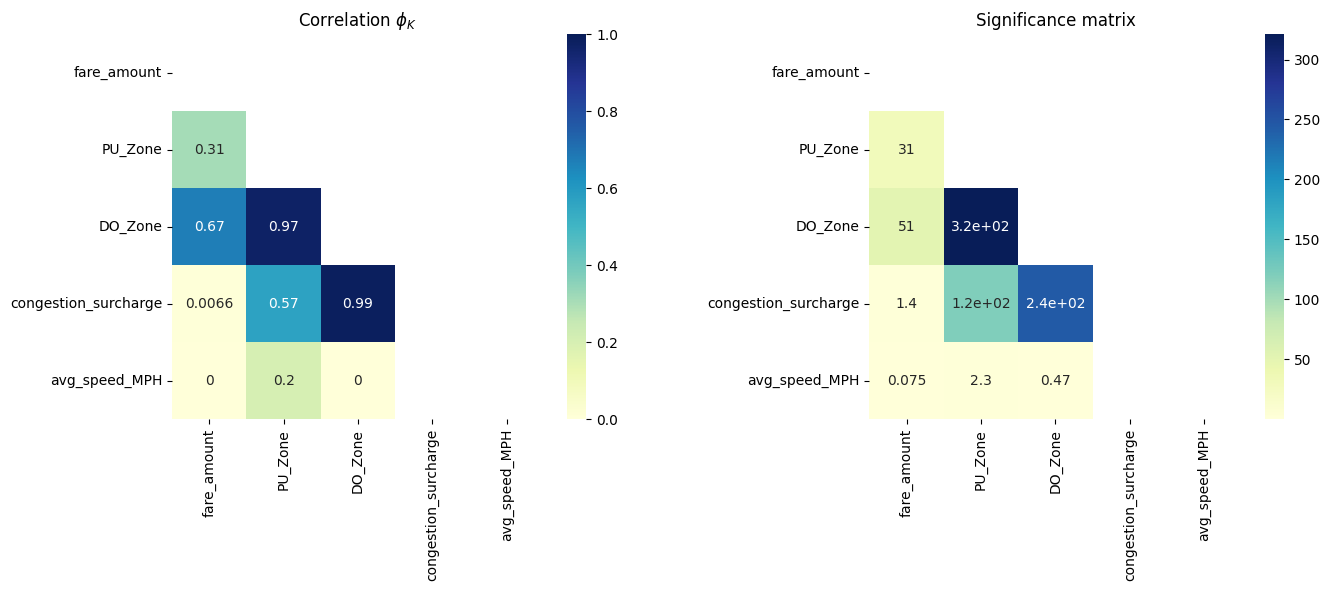

In [130]:
# Corelations matrix untuk kolom congestion_surcharge

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)

cols = ["fare_amount", "PU_Zone","DO_Zone", "congestion_surcharge", "avg_speed_MPH"]

corr = df[cols].phik_matrix()
corr_mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=corr_mask, vmin=0, vmax=1, annot=True, cmap="YlGnBu", ax=ax[0])

sig = df[cols].significance_matrix()
sig_mask = np.triu(np.ones_like(sig, dtype=bool))
sns.heatmap(sig, mask=sig_mask, annot=True, cmap="YlGnBu", ax=ax[1])

ax[0].set_title(f"Correlation $\phi_K$")
ax[1].set_title(f"Significance matrix")

**Insight:**
<br>Dari grafik diatas kita bisa menyimpulkan bahwa "congestion_surcharge" berkolerasi dengan "DO_Zone" yaitu sebesar 0.99%. Sehingga kita bisa meng-imputasi menggunakan peluang bersyarat terhadap zona dropoff.

Selanjutnya kita akan melakukan cross-tabulasi (count) congestion_surcharge dan zona dropff, kemudian melakukan sort_values berdasarkan congestion_surcharge == 2.75

In [131]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,11.02,2.58,14.05,1.0,166,143,1.0,14.90,1.0,0.5,4.03,0.0,1.0,2.75,24.18,1.0,1.0,Manhattan,Manhattan,Morningside Heights,Lincoln Square West,Boro Zone,Yellow Zone,1575590,1575590.0,75492.477273,75492.477273
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,6.77,1.81,16.04,1.0,24,43,1.0,10.70,1.0,0.5,2.64,0.0,1.0,0.00,15.84,1.0,1.0,Manhattan,Manhattan,Bloomingdale,Central Park,Yellow Zone,Yellow Zone,1575590,1575590.0,75492.477273,75492.477273
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,6.33,0.00,0.00,1.0,223,179,1.0,7.20,1.0,0.5,1.94,0.0,1.0,0.00,11.64,1.0,1.0,Queens,Queens,Steinway,Old Astoria,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,5.82,1.30,13.40,1.0,41,238,1.0,6.50,0.5,1.5,1.70,0.0,1.0,0.00,10.20,1.0,1.0,Manhattan,Manhattan,Central Harlem,Upper West Side North,Boro Zone,Yellow Zone,1575590,1575590.0,75492.477273,75492.477273
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,5.97,1.10,11.06,1.0,41,74,1.0,6.00,0.5,1.5,0.00,0.0,1.0,0.00,8.00,1.0,1.0,Manhattan,Manhattan,Central Harlem,East Harlem North,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67494,2,2023-01-31 22:29:00,2023-01-31 22:42:00,13.00,4070.82,18788.40,NaN,49,62,NaN,15.70,0.0,0.0,0.00,0.0,1.0,NaN,16.70,NaN,NaN,Brooklyn,Brooklyn,Clinton Hill,Crown Heights South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865
67495,2,2023-01-31 22:40:00,2023-01-31 22:48:00,8.00,2.14,16.05,NaN,10,205,NaN,4.41,0.0,0.0,0.00,0.0,1.0,NaN,5.41,NaN,NaN,Queens,Queens,Baisley Park,Saint Albans,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085
67496,2,2023-01-31 23:46:00,2023-02-01 00:02:00,16.00,3.44,12.90,NaN,66,37,NaN,16.53,0.0,0.0,3.51,0.0,1.0,NaN,21.04,NaN,NaN,Brooklyn,Brooklyn,DUMBO/Vinegar Hill,Bushwick South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865
67497,2,2023-01-31 23:01:00,2023-01-31 23:19:00,18.00,3.03,10.10,NaN,225,189,NaN,14.98,0.0,0.0,3.20,0.0,1.0,NaN,19.18,NaN,NaN,Brooklyn,Brooklyn,Stuyvesant Heights,Prospect Heights,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865


In [132]:
# Handling congestion_surcharges

# Membuat cross-tabulasi congestion surcharge dan zona dropff
cong_surcharge = pd.crosstab(df.DO_Zone, df.congestion_surcharge, margins=True)

# Mengurutkan frekuensi congestion_surcharge dari nilai tertinggi
cong_surcharge.sort_values(by=2.75, ascending=False)

congestion_surcharge,0.0,2.75,All
DO_Zone,,,
All,46312,16879,63191
Upper East Side North,163,2493,2656
Upper West Side North,822,1417,2239
Yorkville West,101,1410,1511
Upper West Side South,5,1398,1403
...,...,...,...
Homecrest,52,0,52
Howard Beach,28,0,28
Hunts Point,22,0,22


Setelah kita dapat jumlah trip yang sering terjadi kemacetan, maka selanjutnya kita dapat menghitung kemungkinan terjadinya kemacetan tersebut melalui peluang berikut:
<br>**P(congestion | DO_Zone) = P(congestion ∩ DO_Zone) / P(DO_Zone)**

In [133]:
# Perhitungan peluang
p_cong = (cong_surcharge.iloc[:-1,1] / cong_surcharge.iloc[-1,-1]) / (cong_surcharge.iloc[:-1,2] / cong_surcharge.iloc[-1,-1])

# Memberi nama untuk series
p_cong.name = "p_cong"
p_cong

DO_Zone
Allerton/Pelham Gardens    0.000000
Alphabet City              0.967213
Astoria                    0.008101
Astoria Park               0.000000
Auburndale                 0.000000
                             ...   
Woodlawn/Wakefield         0.000000
Woodside                   0.003630
World Trade Center         0.894737
Yorkville East             0.994145
Yorkville West             0.933157
Name: p_cong, Length: 245, dtype: float64

In [134]:
print((p_cong>0.7).sum(), (p_cong<=0.7).sum())

47 198


Selanjutnya kita akan melakukan proses imputasi untuk congestion_surcharge yaitu dengan:
1. Menggabungkan dataframe df dengan data peluang bersyarat (p_cong)
2. Mengubah float nan menjadi np.nan (library math) #Karena kita tidak bisa melakukan imput 
3. Lakukan imputasi jika peluang macet > 0.7 maka kita `asumsikan` bahwa trip tersebut macet ("congestion_surcharge" == 2.75), selain itu "congestion_surcharge" == 0

In [135]:
# 1. Menggabungkan peluang bersyarat dengan data missing values
df = df.merge(p_cong, how='left', left_on='DO_Zone', right_index=True)

In [136]:
# 2. Mengubah float nan menjadi np.nan
df.p_cong = df.p_cong.apply(lambda x: np.nan if math.isnan(x) else x)

In [137]:
# 3. Imputasi congestion_surcharge dengan batasan peluang == 0.7
df.congestion_surcharge = np.where(df.p_cong.isna().values, np.nan, np.where(df.p_cong > 0.7, 2.75, 0))

In [138]:
# Cek kembali apakah masih ada data yang nan

df[df.congestion_surcharge.isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong
65425,2,2023-01-17 13:58:00,2023-01-17 14:09:00,11.0,2.57,14.02,NaN,185,58,NaN,19.47,0.0,0.0,1.50,0.0,1.0,NaN,21.97,NaN,NaN,Bronx,Bronx,Pelham Parkway,Country Club,Boro Zone,Boro Zone,1382480,1382480.0,43097.64,43097.64,NaN
67106,2,2023-01-28 20:20:00,2023-01-28 20:34:00,14.0,6.42,27.51,NaN,167,58,NaN,19.34,0.0,0.0,0.25,0.0,1.0,NaN,20.59,NaN,NaN,Bronx,Bronx,Morrisania/Melrose,Country Club,Boro Zone,Boro Zone,1382480,1382480.0,43097.64,43097.64,NaN


**Insight:**
<br>Pada zona dropoff "DO_Zone" == Country Club, kita tidak memiliki riwayat data yang menunjukan bahwa "DO_Zone" == Country Club merupakan zona macet atau tidak (ditandai dengan tidak adanya data/ missing value di kolom congestion_surcharge pada "DO_Zone" == Country Club)
<br>Solusinya kita bisa drop baris tersebut karena "congestion_surcharge" hanya berkolerasi dengan "DO_Zone", kita juga tidak bisa men-justifikasi bahwa "DO_Zone" tersebut termasuk kedalam kategori macet atau tidak, dan data missing hanya tersisa 2 baris

In [139]:
# Drop baris "DO_Zone" == Country Club (n=2)

drop_index = df[df.congestion_surcharge.isna()].index
df.drop(drop_index, inplace=True)

In [140]:
# Cek kembali apakah masih ada data yang nan

df[df.congestion_surcharge.isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong


##### 4.2. DO_population & DO_density

In [141]:
# Cek missing value

df[(df["DO_population"].isna() | df["DO_density"].isna())]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong
820,2,2023-01-01 16:08:11,2023-01-01 17:02:53,54.70,14.81,16.24,5.0,65,1,3.0,110.00,0.00,0.0,22.20,0.00,1.0,0.0,133.20,1.0,2.0,Brooklyn,EWR,Downtown Brooklyn/MetroTech,Newark Airport,Boro Zone,EWR,2504700,NaN,41710.864865,NaN,0.1
1419,2,2023-01-02 08:57:41,2023-01-02 09:39:53,42.20,26.94,38.30,3.0,166,1,3.0,121.70,0.00,0.0,33.94,13.75,0.3,0.0,169.69,1.0,1.0,Manhattan,EWR,Morningside Heights,Newark Airport,Boro Zone,EWR,1575590,NaN,75492.477273,NaN,0.1
1939,2,2023-01-02 14:53:46,2023-01-02 15:41:00,47.23,14.54,18.47,5.0,65,1,4.0,110.00,0.00,0.0,10.00,0.00,1.0,0.0,121.00,1.0,2.0,Brooklyn,EWR,Downtown Brooklyn/MetroTech,Newark Airport,Boro Zone,EWR,2504700,NaN,41710.864865,NaN,0.1
4922,2,2023-01-04 08:26:32,2023-01-04 09:03:20,36.80,26.76,43.63,3.0,166,1,1.0,118.20,0.00,0.0,0.00,13.75,1.0,0.0,132.95,1.0,1.0,Manhattan,EWR,Morningside Heights,Newark Airport,Boro Zone,EWR,1575590,NaN,75492.477273,NaN,0.1
7705,2,2023-01-05 12:58:51,2023-01-05 13:27:40,28.82,14.49,30.17,5.0,65,1,1.0,110.00,0.00,0.0,20.00,11.75,1.0,0.0,142.75,1.0,2.0,Brooklyn,EWR,Downtown Brooklyn/MetroTech,Newark Airport,Boro Zone,EWR,2504700,NaN,41710.864865,NaN,0.1
7970,2,2023-01-05 14:53:00,2023-01-05 16:19:20,86.33,41.74,29.01,1.0,130,1,1.0,114.00,0.00,0.5,0.00,18.30,0.3,0.0,133.10,1.0,1.0,Queens,EWR,Jamaica,Newark Airport,Boro Zone,EWR,2233270,NaN,26896.305085,NaN,0.1
11694,2,2023-01-07 07:22:31,2023-01-07 08:02:00,39.48,19.48,29.60,3.0,166,1,1.0,97.20,0.00,0.0,21.99,11.75,1.0,0.0,131.94,1.0,1.0,Manhattan,EWR,Morningside Heights,Newark Airport,Boro Zone,EWR,1575590,NaN,75492.477273,NaN,0.1
12634,2,2023-01-07 16:53:12,2023-01-07 17:45:02,51.83,27.32,31.63,3.0,75,1,1.0,123.80,0.00,0.0,0.00,20.50,1.0,0.0,145.30,2.0,1.0,Manhattan,EWR,East Harlem South,Newark Airport,Boro Zone,EWR,1575590,NaN,75492.477273,NaN,0.1
17813,2,2023-01-10 12:33:59,2023-01-10 13:16:24,42.42,17.36,24.55,5.0,226,1,3.0,120.00,0.00,0.0,0.00,12.75,1.0,0.0,133.75,2.0,2.0,Queens,EWR,Sunnyside,Newark Airport,Boro Zone,EWR,2233270,NaN,26896.305085,NaN,0.1
23293,2,2023-01-12 18:56:29,2023-01-12 19:45:34,49.08,28.15,34.41,3.0,244,1,5.0,125.20,2.50,0.0,30.29,22.75,1.0,0.0,181.74,1.0,1.0,Manhattan,EWR,Washington Heights South,Newark Airport,Boro Zone,EWR,1575590,NaN,75492.477273,NaN,0.1


In [142]:
# Jumlah data missing

len(df[(df["DO_population"].isna() | df["DO_density"].isna())])

24

**Insight:**
<br>missing value pada kolom "DO_population" dan "DO_density" disebabkan karena lokasi dropoff "DOLocationID" yang ada di bandara Newark. #Bandara Newark tidak diketahui untuk jumlah populasi dan density nya, maka dari itu kita akan isi 0

In [143]:
# Isi missing value dengan nilai 0 "Tidak diketahui jumlah populasi dan density"

df[["DO_population", "DO_density"]] = df[["DO_population", "DO_density"]].fillna(value=0)

In [144]:
# Cek kembali missing value

df[(df["DO_population"].isna() | df["DO_density"].isna())]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong


### **`Kategorikal:`**

#### **1. Cek "RatecodeID" == 99.0** (n=9)
(n=)

In [145]:
# Cek missing value pada kolom trip_type

df[df.trip_type.isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong
1066,1,2023-01-01 19:44:13,2023-01-01 19:58:30,14.28,3.30,13.87,99.0,150,55,1.0,18.20,0.0,1.5,0.00,0.0,1.0,0.00,19.70,1.0,NaN,Brooklyn,Brooklyn,Manhattan Beach,Coney Island,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.026786
2142,1,2023-01-02 16:39:05,2023-01-02 17:31:42,52.62,3.70,4.22,99.0,73,82,1.0,23.50,0.0,1.5,0.00,0.0,1.0,0.00,25.00,1.0,NaN,Queens,Queens,East Flushing,Elmhurst,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.001017
8945,1,2023-01-05 20:33:45,2023-01-05 22:46:41,132.93,6.20,2.80,99.0,14,123,1.0,28.20,0.0,1.5,0.00,0.0,1.0,0.00,29.70,1.0,NaN,Brooklyn,Brooklyn,Bay Ridge,Homecrest,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
13942,1,2023-01-08 11:36:41,2023-01-08 12:14:59,38.30,2.70,4.23,99.0,61,77,1.0,22.50,0.0,1.5,0.00,0.0,1.0,0.00,24.00,1.0,NaN,Brooklyn,Brooklyn,Crown Heights North,East New York/Pennsylvania Avenue,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
28805,1,2023-01-15 13:51:42,2023-01-15 14:37:38,45.93,6.50,8.49,99.0,108,181,1.0,24.20,0.0,1.5,0.00,0.0,1.0,0.00,25.70,1.0,NaN,Brooklyn,Brooklyn,Gravesend,Park Slope,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.011364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67494,2,2023-01-31 22:29:00,2023-01-31 22:42:00,13.00,4070.82,18788.40,NaN,49,62,NaN,15.70,0.0,0.0,0.00,0.0,1.0,0.00,16.70,NaN,NaN,Brooklyn,Brooklyn,Clinton Hill,Crown Heights South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
67495,2,2023-01-31 22:40:00,2023-01-31 22:48:00,8.00,2.14,16.05,NaN,10,205,NaN,4.41,0.0,0.0,0.00,0.0,1.0,0.00,5.41,NaN,NaN,Queens,Queens,Baisley Park,Saint Albans,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.000000
67496,2,2023-01-31 23:46:00,2023-02-01 00:02:00,16.00,3.44,12.90,NaN,66,37,NaN,16.53,0.0,0.0,3.51,0.0,1.0,0.00,21.04,NaN,NaN,Brooklyn,Brooklyn,DUMBO/Vinegar Hill,Bushwick South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.024194
67497,2,2023-01-31 23:01:00,2023-01-31 23:19:00,18.00,3.03,10.10,NaN,225,189,NaN,14.98,0.0,0.0,3.20,0.0,1.0,0.00,19.18,NaN,NaN,Brooklyn,Brooklyn,Stuyvesant Heights,Prospect Heights,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.008333


In [146]:
df[df.RatecodeID == "99.0"]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong
1066,1,2023-01-01 19:44:13,2023-01-01 19:58:30,14.28,3.3,13.87,99.0,150,55,1.0,18.2,0.0,1.5,0.0,0.0,1.0,0.00,19.7,1.0,NaN,Brooklyn,Brooklyn,Manhattan Beach,Coney Island,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.026786
2142,1,2023-01-02 16:39:05,2023-01-02 17:31:42,52.62,3.7,4.22,99.0,73,82,1.0,23.5,0.0,1.5,0.0,0.0,1.0,0.00,25.0,1.0,NaN,Queens,Queens,East Flushing,Elmhurst,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.001017
8945,1,2023-01-05 20:33:45,2023-01-05 22:46:41,132.93,6.2,2.80,99.0,14,123,1.0,28.2,0.0,1.5,0.0,0.0,1.0,0.00,29.7,1.0,NaN,Brooklyn,Brooklyn,Bay Ridge,Homecrest,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
13942,1,2023-01-08 11:36:41,2023-01-08 12:14:59,38.30,2.7,4.23,99.0,61,77,1.0,22.5,0.0,1.5,0.0,0.0,1.0,0.00,24.0,1.0,NaN,Brooklyn,Brooklyn,Crown Heights North,East New York/Pennsylvania Avenue,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
28805,1,2023-01-15 13:51:42,2023-01-15 14:37:38,45.93,6.5,8.49,99.0,108,181,1.0,24.2,0.0,1.5,0.0,0.0,1.0,0.00,25.7,1.0,NaN,Brooklyn,Brooklyn,Gravesend,Park Slope,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.011364
29369,1,2023-01-15 17:52:52,2023-01-15 22:11:55,259.05,1.6,0.37,99.0,150,123,1.0,15.2,0.0,1.5,0.0,0.0,1.0,0.00,16.7,1.0,NaN,Brooklyn,Brooklyn,Manhattan Beach,Homecrest,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
35573,1,2023-01-19 01:07:59,2023-01-19 01:17:19,9.33,0.6,3.86,99.0,90,68,1.0,15.2,0.0,1.5,0.0,0.0,1.0,2.75,16.7,1.0,NaN,Manhattan,Manhattan,Flatiron,East Chelsea,Yellow Zone,Yellow Zone,1575590,1575590.0,75492.477273,75492.477273,0.944954
41970,1,2023-01-21 20:29:58,2023-01-22 02:59:25,389.45,1.4,0.22,99.0,150,123,1.0,15.2,0.0,1.5,0.0,0.0,1.0,0.00,16.7,1.0,NaN,Brooklyn,Brooklyn,Manhattan Beach,Homecrest,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
44710,1,2023-01-23 13:45:11,2023-01-23 23:36:42,591.52,28.3,2.87,99.0,244,248,1.0,50.2,0.0,1.5,0.0,0.0,1.0,0.00,51.7,1.0,NaN,Manhattan,Bronx,Washington Heights South,West Farms/Bronx River,Boro Zone,Boro Zone,1575590,1382480.0,75492.477273,43097.640000,0.000000


**Insight:**
<br>Seluruh "RatecodeID" == 99.0 (n=9) adalah missing value pada kolom "trip_type", maka kita akan drop "RatecodeID" == 99.0 (n=9)

In [147]:
# Drop "RatecodeID" == 99.0

index_drop = df[df["RatecodeID"] == "99.0"].index
df.drop(index_drop, inplace=True)

In [148]:
# Cek kembali RatecodeID == 99.0

df[df.RatecodeID == "99.0"]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong


#### **2. Cek missing value**
(n=)

<Axes: >

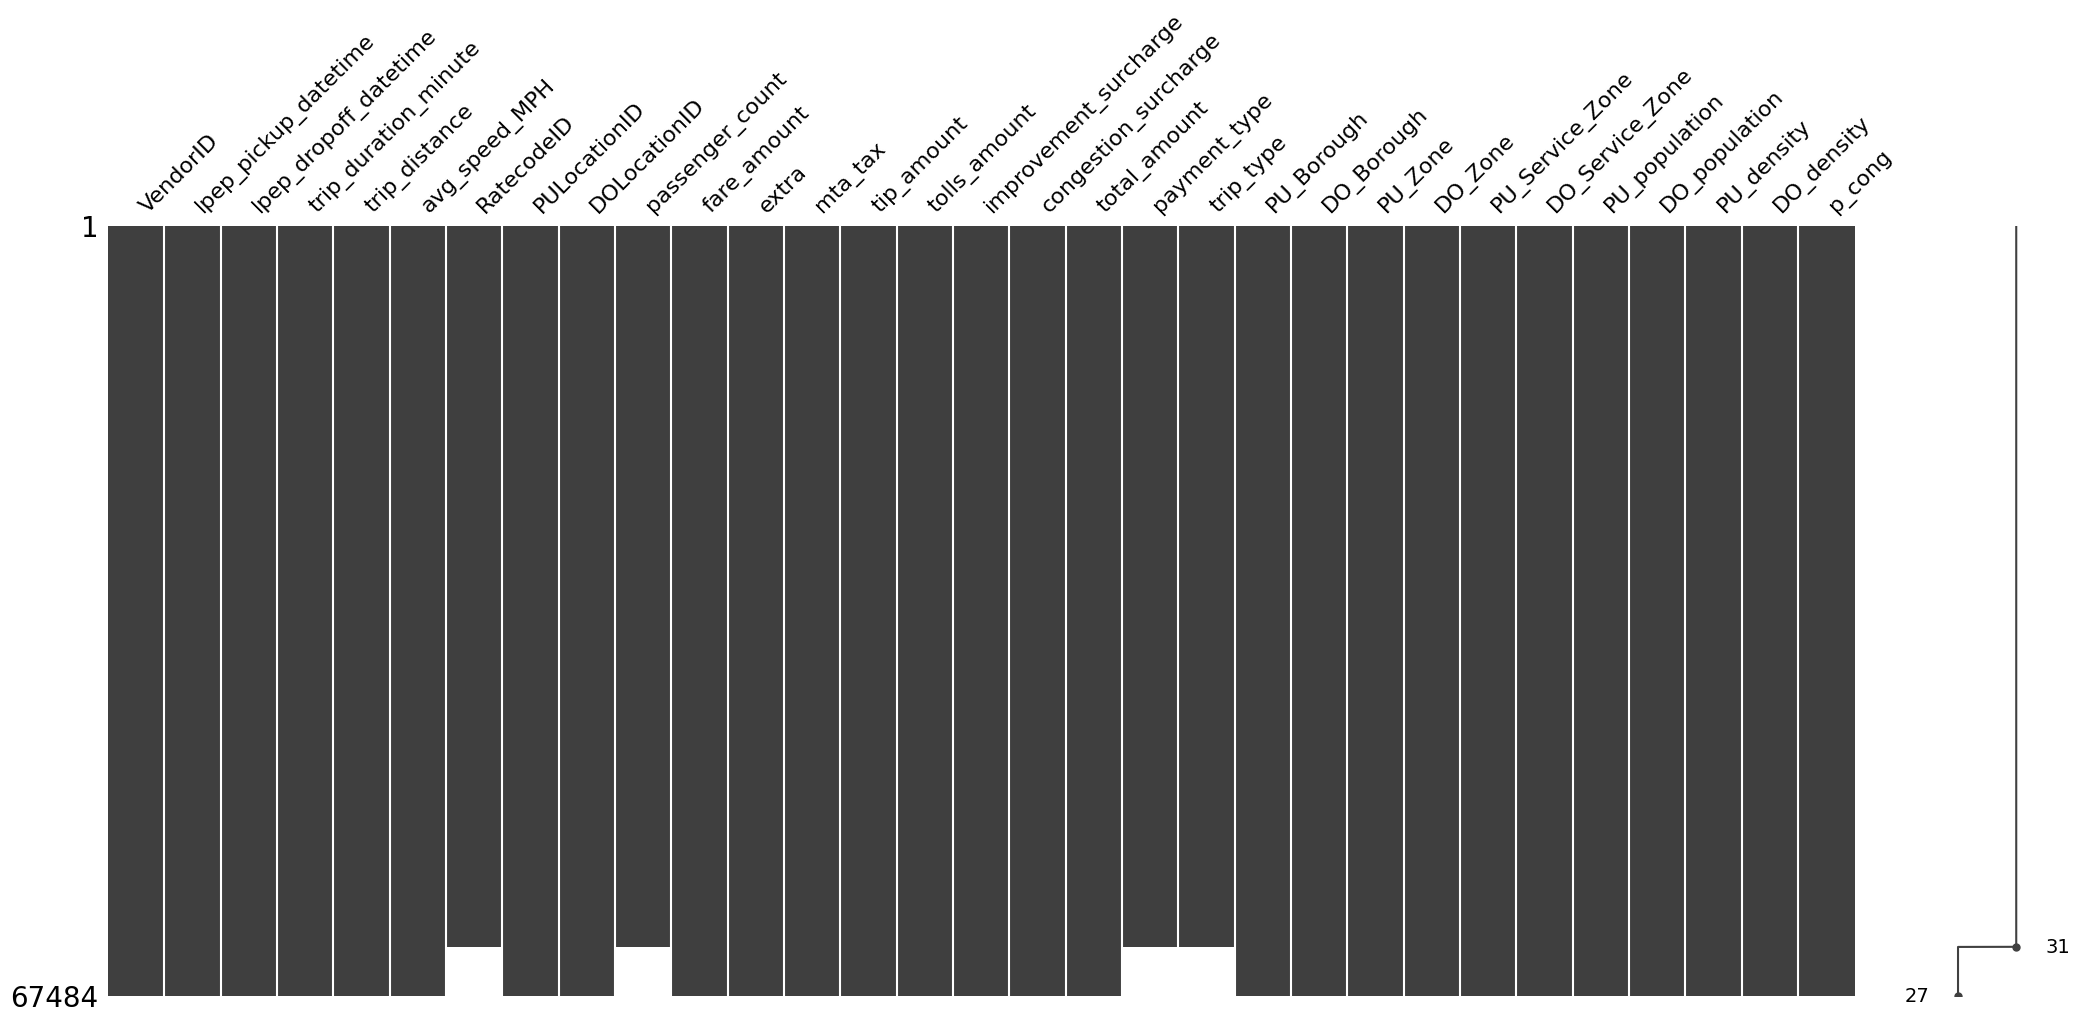

In [149]:
# Check missing value

msno.matrix(df)

**Insight:**
1. Lokasi missing value untuk setiap kolom terjadi pada baris yang sama (MAR)
2. Missing value di kolom RatecodeID diisi dengan melihat DO_Zone 
3. Missing value di kolom passanger_count diisi minimum passanger dalam setiap trip (1)
4. Missing value di kolom payment_type diisi kategori 5 (unknown)
5. Missing value di kolom trip_type diisi diisi kategori baru 3 (other)

##### **RatecodeID**

Pengisian missing value untuk RatecodeID melihat aturan yang ditetapkan oleh pihak NYC TLC Trip [Di sini](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page):
1. RatecodeID == 1, ketika standard rate yang ditetapkan pada trip
2. RatecodeID == 2, ketika dropoff (DO_Zone) ke "JFK Airport" dengan pickup (PU_Zone) dari "Manhattan", `Atau sebaliknya`
3. RatecodeID == 3, ketika dropoff (DO_Zone) ke "Newark Airport"
4. RatecodeID == 4, ketika dropoff (DO_Zone) ke "Nassau" atau "Westchester"
5. RatecodeID == 5, ketika diakhir perjalanan adalah "Negotiated Fare", dapat dikatakan trip dengan fare_amount bernilai bulat
6. RatecodeID == 6, ketika Group ride

In [150]:
# Cek RatecodeID unique

df.RatecodeID.unique()

array(['1.0', '5.0', '3.0', '2.0', '4.0', nan], dtype=object)

In [151]:
# Replace RatecodeID berdasarkan aturan yang ditetapkan

df.RatecodeID = np.where(df.RatecodeID == "5.0", df.RatecodeID, \
                         np.where(((df.PU_Borough == 'Manhattan') & (df.DO_Zone == 'JFK Airport')) | ((df.PU_Zone == 'JFK Airport') & (df.DO_Borough == 'Manhattan')), "2.0",\
                                  np.where(df.DO_Zone == 'Newark Airport', "3.0", "1.0")))

In [152]:
# Cek kembali RatecodeID unique

df.RatecodeID.unique()

array(['1.0', '5.0', '2.0', '3.0'], dtype=object)

##### **passenger_count**

In [153]:
# Cek value_counts passanger_count

df.passenger_count.value_counts().sort_index()

passenger_count
0.0      322
1.0    53691
2.0     5047
3.0      943
4.0      360
5.0     1763
6.0     1050
7.0        3
8.0        2
9.0        1
Name: count, dtype: int64

In [154]:
df.passenger_count.isna().sum()

4302

**Insight:**
<br>Terdapat nilai "passanger_count" == 0 sebanyak 322 trip kemudian kita akan imputasi ke nilai minimum yaitu 1 penumpang, dan untuk nilai "passanger_count" > 6 sebanyak 6 trip kita akan imputasi ke nilai maksimum yaitu 6 penumpang

In [155]:
# Replace RatecodeID berdasarkan aturan yang ditetapkan

df.passenger_count = np.where(df.passenger_count.isin(["1.0", "2.0", "3.0", "4.0", "5.0", "6.0"]), df.passenger_count, \
                         np.where((df.passenger_count.isin(["7.0", "8.0", "9.0"])), "6.0", "1.0"))

In [156]:
# Cek kembali value_counts passanger_count

df.passenger_count.value_counts().sort_index()

passenger_count
1.0    58315
2.0     5047
3.0      943
4.0      360
5.0     1763
6.0     1056
Name: count, dtype: int64

##### **payment_type**

In [157]:
# Check missing value

df[df.payment_type.isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong
63195,2,2023-01-01 00:28:00,2023-01-01 00:54:00,26.0,9.33,21.53,1.0,7,17,1.0,36.03,0.0,0.0,7.41,0.0,1.0,0.00,44.44,NaN,NaN,Queens,Brooklyn,Astoria,Bedford,Boro Zone,Boro Zone,2233270,2504700.0,26896.305085,41710.864865,0.044828
63196,2,2023-01-01 00:39:00,2023-01-01 00:52:00,13.0,2.67,12.32,1.0,37,37,1.0,14.55,0.0,0.0,3.11,0.0,1.0,0.00,18.66,NaN,NaN,Brooklyn,Brooklyn,Bushwick South,Bushwick South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.024194
63197,2,2023-01-01 00:58:00,2023-01-01 01:21:00,23.0,7.39,19.28,1.0,80,7,1.0,32.13,0.0,0.0,6.63,0.0,1.0,0.00,39.76,NaN,NaN,Brooklyn,Queens,East Williamsburg,Astoria,Boro Zone,Boro Zone,2504700,2233270.0,41710.864865,26896.305085,0.008101
63198,2,2023-01-01 00:35:00,2023-01-01 00:55:00,20.0,4.04,12.12,1.0,169,42,1.0,17.85,0.0,0.0,0.00,0.0,1.0,0.00,18.85,NaN,NaN,Bronx,Manhattan,Mount Hope,Central Harlem North,Boro Zone,Boro Zone,1382480,1575590.0,43097.640000,75492.477273,0.004450
63199,2,2023-01-01 00:45:00,2023-01-01 00:55:00,10.0,3.86,23.16,1.0,42,262,1.0,19.67,0.0,0.0,4.68,0.0,1.0,2.75,28.10,NaN,NaN,Manhattan,Manhattan,Central Harlem North,Yorkville East,Boro Zone,Yellow Zone,1575590,1575590.0,75492.477273,75492.477273,0.994145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67494,2,2023-01-31 22:29:00,2023-01-31 22:42:00,13.0,4070.82,18788.40,1.0,49,62,1.0,15.70,0.0,0.0,0.00,0.0,1.0,0.00,16.70,NaN,NaN,Brooklyn,Brooklyn,Clinton Hill,Crown Heights South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
67495,2,2023-01-31 22:40:00,2023-01-31 22:48:00,8.0,2.14,16.05,1.0,10,205,1.0,4.41,0.0,0.0,0.00,0.0,1.0,0.00,5.41,NaN,NaN,Queens,Queens,Baisley Park,Saint Albans,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.000000
67496,2,2023-01-31 23:46:00,2023-02-01 00:02:00,16.0,3.44,12.90,1.0,66,37,1.0,16.53,0.0,0.0,3.51,0.0,1.0,0.00,21.04,NaN,NaN,Brooklyn,Brooklyn,DUMBO/Vinegar Hill,Bushwick South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.024194
67497,2,2023-01-31 23:01:00,2023-01-31 23:19:00,18.0,3.03,10.10,1.0,225,189,1.0,14.98,0.0,0.0,3.20,0.0,1.0,0.00,19.18,NaN,NaN,Brooklyn,Brooklyn,Stuyvesant Heights,Prospect Heights,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.008333


In [158]:
# Isi missing value dengan nilai 5 "unknown"

df.payment_type.fillna("5.0", inplace=True)

In [159]:
# Check kembali missing value

df[df.payment_type.isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong


In [160]:
df.payment_type.value_counts().sort_index()

payment_type
1.0    40253
2.0    22375
3.0      460
4.0       92
5.0     4304
Name: count, dtype: int64

##### **trip_type**

In [161]:
# Check missing value

df[df.trip_type.isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong
63195,2,2023-01-01 00:28:00,2023-01-01 00:54:00,26.0,9.33,21.53,1.0,7,17,1.0,36.03,0.0,0.0,7.41,0.0,1.0,0.00,44.44,5.0,NaN,Queens,Brooklyn,Astoria,Bedford,Boro Zone,Boro Zone,2233270,2504700.0,26896.305085,41710.864865,0.044828
63196,2,2023-01-01 00:39:00,2023-01-01 00:52:00,13.0,2.67,12.32,1.0,37,37,1.0,14.55,0.0,0.0,3.11,0.0,1.0,0.00,18.66,5.0,NaN,Brooklyn,Brooklyn,Bushwick South,Bushwick South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.024194
63197,2,2023-01-01 00:58:00,2023-01-01 01:21:00,23.0,7.39,19.28,1.0,80,7,1.0,32.13,0.0,0.0,6.63,0.0,1.0,0.00,39.76,5.0,NaN,Brooklyn,Queens,East Williamsburg,Astoria,Boro Zone,Boro Zone,2504700,2233270.0,41710.864865,26896.305085,0.008101
63198,2,2023-01-01 00:35:00,2023-01-01 00:55:00,20.0,4.04,12.12,1.0,169,42,1.0,17.85,0.0,0.0,0.00,0.0,1.0,0.00,18.85,5.0,NaN,Bronx,Manhattan,Mount Hope,Central Harlem North,Boro Zone,Boro Zone,1382480,1575590.0,43097.640000,75492.477273,0.004450
63199,2,2023-01-01 00:45:00,2023-01-01 00:55:00,10.0,3.86,23.16,1.0,42,262,1.0,19.67,0.0,0.0,4.68,0.0,1.0,2.75,28.10,5.0,NaN,Manhattan,Manhattan,Central Harlem North,Yorkville East,Boro Zone,Yellow Zone,1575590,1575590.0,75492.477273,75492.477273,0.994145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67494,2,2023-01-31 22:29:00,2023-01-31 22:42:00,13.0,4070.82,18788.40,1.0,49,62,1.0,15.70,0.0,0.0,0.00,0.0,1.0,0.00,16.70,5.0,NaN,Brooklyn,Brooklyn,Clinton Hill,Crown Heights South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
67495,2,2023-01-31 22:40:00,2023-01-31 22:48:00,8.0,2.14,16.05,1.0,10,205,1.0,4.41,0.0,0.0,0.00,0.0,1.0,0.00,5.41,5.0,NaN,Queens,Queens,Baisley Park,Saint Albans,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.000000
67496,2,2023-01-31 23:46:00,2023-02-01 00:02:00,16.0,3.44,12.90,1.0,66,37,1.0,16.53,0.0,0.0,3.51,0.0,1.0,0.00,21.04,5.0,NaN,Brooklyn,Brooklyn,DUMBO/Vinegar Hill,Bushwick South,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.024194
67497,2,2023-01-31 23:01:00,2023-01-31 23:19:00,18.0,3.03,10.10,1.0,225,189,1.0,14.98,0.0,0.0,3.20,0.0,1.0,0.00,19.18,5.0,NaN,Brooklyn,Brooklyn,Stuyvesant Heights,Prospect Heights,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.008333


In [162]:
# Isi missing value dengan nilai 3 "OTHER"

df.trip_type.fillna("3.0", inplace=True)

In [163]:
# Check kembali missing value

df[df.trip_type.isna()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong


In [164]:
df.trip_type.unique()

array(['1.0', '2.0', '3.0'], dtype=object)

## 3. Cek Kembali dataset `df`
(n=67306)

In [165]:
checkData(df)

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,VendorID,object,67484,0,0.0,2,"[2, 1]"
1,lpep_pickup_datetime,datetime64[s],67484,0,0.0,65888,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
2,lpep_dropoff_datetime,datetime64[s],67484,0,0.0,65824,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 202..."
3,trip_duration_minute,float64,67484,0,0.0,3598,"[11.02, 6.77, 6.33, 5.82, 5.97, 17.55, 17.42, ..."
4,trip_distance,float64,67484,0,0.0,1800,"[2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1..."
5,avg_speed_MPH,float64,67484,0,0.0,3568,"[14.05, 16.04, 0.0, 13.4, 11.06, 9.5, 13.09, 8..."
6,RatecodeID,object,67484,0,0.0,4,"[1.0, 5.0, 2.0, 3.0]"
7,PULocationID,object,67484,0,0.0,222,"[166, 24, 223, 41, 181, 255, 75, 66, 195, 83, ..."
8,DOLocationID,object,67484,0,0.0,246,"[143, 43, 179, 238, 74, 262, 45, 75, 166, 140,..."
9,passenger_count,object,67484,0,0.0,6,"[1.0, 2.0, 4.0, 3.0, 6.0, 5.0]"


In [166]:
df.drop_duplicates(subset=["lpep_pickup_datetime", "lpep_dropoff_datetime"], keep="last", inplace=True)

In [167]:
# Cek kembali value_counts passanger_count

df.passenger_count.value_counts().sort_index()

passenger_count
1.0    58185
2.0     5013
3.0      936
4.0      358
5.0     1759
6.0     1055
Name: count, dtype: int64

## 4. Handling Outlier
(n=67306)

Jika dilihat dari deskriptif statistik sederhana diketahui terdapat 6 kolom yang secara domain knowladge dirasa tidak masuk akal, yaitu kolom "trip_duration_minute", "avg_speed_MPH", "trip_distance", "fare_amount", "tip_amount", dan "total_amount". Namun untuk kolom "avg_speed_MPH" merupakan proses perhitungan dari kolom "trip_distance" dan "trip_duration_minute", sedangkan untuk kolom "total_amount" merupakan proses perhitungan dari total keseluruhan biaya yang dikeluarkan. Sehingga kita hanya akan cek 4 dari 6 kolom, yaitu "trip_duration_minute", "trip_distance", "fare_amount", dan "tip_amount".

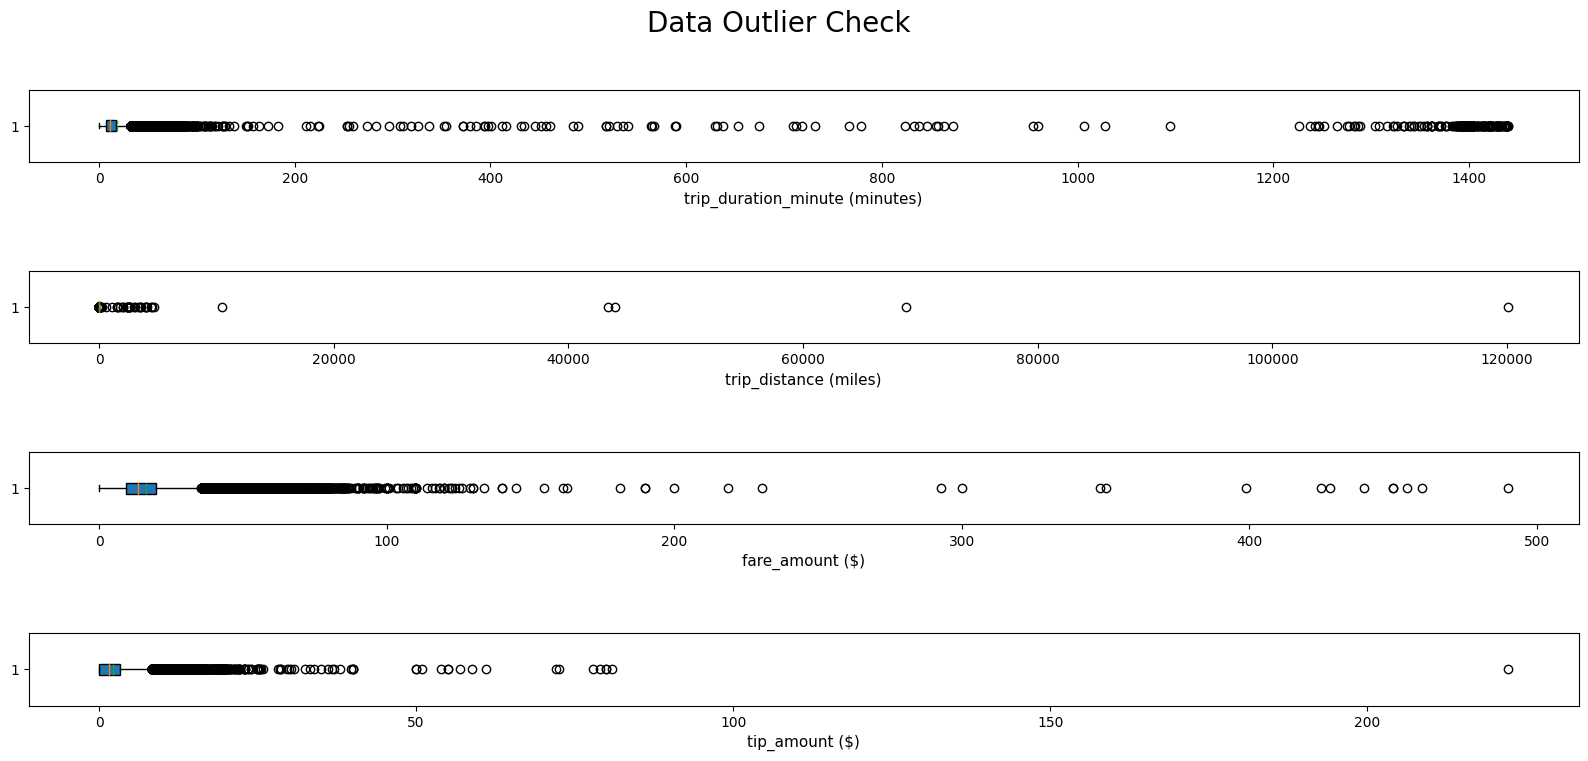

In [168]:
# Check Pesebaran data

fig, axes = plt.subplots(4, 1, figsize=(20, 8))
axes[0].boxplot(df.trip_duration_minute, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[1].boxplot(df.trip_distance, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[2].boxplot(df.fare_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[3].boxplot(df.tip_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)

axes[0].set_xlabel("trip_duration_minute (minutes)", fontsize=11)
axes[1].set_xlabel("trip_distance (miles)", fontsize=11)
axes[2].set_xlabel("fare_amount ($)", fontsize=11)
axes[3].set_xlabel("tip_amount ($)", fontsize=11)

fig.suptitle("Data Outlier Check", fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, wspace=1.5, hspace=1.5)
plt.show()

**Insight:**
1. Ke-empat data tersebut berdistribusi tidak normal
2. Terdapat data outlier pada setiap kolomnya
3. Perhatikan juga data yang bernilai 0 
4. kita bisa membatasi masing-masing data dengan `domain knowladge` sebagai berikut:
    * "trip_duration_minute" dapat dibatasi dengan durasi yang masuk akal ialah `2 jam` [di sini](https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_54.pdf)
    * "trip_distance" dapat dibatasi dengan jarak terjauh yang mungkin ditempuh untuk menuju dua titik di New York City sejauh `50mil` [di sini](https://goo.gl/maps/utRjU3kDctBT3qD66)
    * "fare_amount" dapat dibatasi tarif tertinggi untuk perjalanan `ke Airport` (dijelaskan selanjutnya)
    * "tip_amount" dapat dibatasi dengan pemberian tip yang logis yaitu tip tidak lebih besar dari `dua kali nilai "fare_amount"` (tarif dasar)

### Mengganti data yang diluar batasan menjadi missing

In [169]:
# Membuat salinan untuk df sebelum handling outlier

df_old = df.copy()

#### fare_amount

"fare_amount" atau tarif dasar minimum untuk setiap RatecodeID adalah berbeda. Berikut tarif dasar yang diberikan:

| RatecodeID | End of the Trip | Fare Amount |
| ---------- | --------------- | ----------- |
| 1 | Standard Rate | $3 |
| 2 | JFK Airport | $70 |
| 3 | Newark Airport | $23 |
| 4 | Nassau or Westchester | $6 |
| 5 | Negotiated Fare | by negotiations |

Tarif berikutnya akan berlaku ketika taxi sudah berjalan sejauh 0.2mill dan atau waktu sudah lebih dari 60 detik (1menit) [Di sini](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page). Maka dari itu kita dapat mengasumsikan bahwa perjalanan dengan trip_distance dibawah 2mill dan atau trip_duration_minute dibawah 60s akan mengikuti tarif dasar untuk setiap RatecodeID. #Untuk RatecodeID 5, akan mengikuti sesuai dengan tarif yang telah disepakati antara driver dan customer. Maka fare_amount dengan RatecodeID 5 tidak akan dirubah fare_amount-nya.

In [170]:
# Cek apakah ada trip_distance dibawah 2mill dan atau trip_duration_minute dibawah 60s dengan harga diatas fare_amount untuk setiap RateodeID

df[((df.trip_duration_minute <= 1) & (df.trip_distance <= 0.2) & (df.RatecodeID == "1.0") & (df.fare_amount > 3)) |
   ((df.trip_duration_minute <= 1) & (df.trip_distance <= 0.2) & (df.RatecodeID == "2.0") & (df.fare_amount > 70)) |
   ((df.trip_duration_minute <= 1) & (df.trip_distance <= 0.2) & (df.RatecodeID == "3.0") & (df.fare_amount > 23))]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong
240,2,2023-01-01 03:55:21,2023-01-01 03:55:32,0.18,0.00,0.0,1.0,179,179,1.0,70.00,0.0,0.5,0.00,0.0,1.0,0.0,71.50,1.0,1.0,Queens,Queens,Old Astoria,Old Astoria,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.008547
445,2,2023-01-01 11:40:14,2023-01-01 11:40:34,0.33,0.00,0.0,1.0,65,65,1.0,70.00,0.0,0.5,0.00,0.0,1.0,0.0,71.50,2.0,1.0,Brooklyn,Brooklyn,Downtown Brooklyn/MetroTech,Downtown Brooklyn/MetroTech,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.025641
704,2,2023-01-01 15:21:15,2023-01-01 15:21:20,0.08,0.01,7.5,1.0,75,75,1.0,70.00,0.0,0.5,0.00,0.0,1.0,0.0,71.50,2.0,1.0,Manhattan,Manhattan,East Harlem South,East Harlem South,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273,0.014641
720,2,2023-01-01 15:55:38,2023-01-01 15:56:38,1.00,0.11,6.6,1.0,41,41,2.0,3.70,0.0,0.5,0.00,0.0,1.0,0.0,5.20,2.0,1.0,Manhattan,Manhattan,Central Harlem,Central Harlem,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273,0.004745
744,2,2023-01-01 15:33:53,2023-01-01 15:34:13,0.33,0.00,0.0,1.0,74,74,1.0,70.00,0.0,0.5,0.00,0.0,1.0,0.0,71.50,2.0,1.0,Manhattan,Manhattan,East Harlem North,East Harlem North,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273,0.004853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66251,2,2023-01-23 04:49:00,2023-01-23 04:49:00,0.00,0.00,0.0,1.0,83,83,1.0,12.02,0.0,0.0,0.00,0.0,1.0,0.0,13.02,5.0,3.0,Queens,Queens,Elmhurst/Maspeth,Elmhurst/Maspeth,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.000000
66663,2,2023-01-25 17:30:00,2023-01-25 17:31:00,1.00,0.09,5.4,1.0,82,82,1.0,20.35,0.0,0.0,1.58,0.0,1.0,0.0,22.93,5.0,3.0,Queens,Queens,Elmhurst,Elmhurst,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.001017
66770,2,2023-01-26 12:09:00,2023-01-26 12:10:00,1.00,0.02,1.2,1.0,17,225,1.0,25.81,0.0,0.0,7.71,0.0,1.0,0.0,34.52,5.0,3.0,Brooklyn,Brooklyn,Bedford,Stuyvesant Heights,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.009091
67240,2,2023-01-30 03:58:00,2023-01-30 03:59:00,1.00,0.00,0.0,1.0,83,83,1.0,14.41,0.0,0.0,0.00,0.0,1.0,0.0,15.41,5.0,3.0,Queens,Queens,Elmhurst/Maspeth,Elmhurst/Maspeth,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.000000


Ternyata terdapat 83 trip yang fare_amount tidak sesuai dengan asumsi yang sudah disebutkan sebelumnya. maka dari itu kita akan mengganti fare_amount sesuai dengan fare_amount yang seharusnya

In [171]:
# Replace nilai fare_amount

df.fare_amount = np.where(((df.trip_duration_minute <= 60) | (df.trip_distance <= 0.2)) & ((df.RatecodeID == 1) & (df.fare_amount != 3)), 3,\
                           np.where(((df.trip_duration_minute <= 60) | (df.trip_distance <= 0.2)) & ((df.RatecodeID == 2) & (df.fare_amount != 70)), 70,\
                                     np.where(((df.trip_duration_minute <= 60) | (df.trip_distance <= 0.2)) & ((df.RatecodeID == 3) & (df.fare_amount != 23)), 23, df.fare_amount)))

#### trip_duration_minute

Batas bawah == 0

Batas atas == 120 menit (karena untuk kecepatan rata-rata yang duration > 120 menit == 11.58MPH. Hal ini menurut domain knowladge tidak masuk akal karena kecepatan terlalu rendah)

In [172]:
df[df.trip_duration_minute > 120].agg({"avg_speed_MPH": "max"})

avg_speed_MPH    11.58
dtype: float64

In [173]:
df.trip_duration_minute = df.trip_duration_minute.mask(df.trip_duration_minute > 120)

#### trip_distance

Batas bawah == 0

Batas atas == 50 mill (berdasarkan jarak terjauh yang dapat ditempuh)

In [174]:
df.trip_distance = df.trip_distance.mask(df.trip_distance > 50)

#### fare_amount

Batas bawah == 0

Batas atas == $162.6 (dilihat dari nilai maksimum dari fare_amount (trip menuju Bandara JFK))

In [175]:
df[df.RatecodeID.isin(["2.0", "3.0"])].agg({"fare_amount": "max"})

fare_amount    162.6
dtype: float64

In [176]:
df.fare_amount = df.fare_amount.mask(df.fare_amount > df[df.RatecodeID.isin(["2.0", "3.0"])].fare_amount.max())

#### tip_amount

Batas bawah == 0

Batas atas == tip_amount tidak lebih dari 2 kali fare_amount

In [177]:
df.tip_amount = df.tip_amount.mask((df.tip_amount > 2*df.fare_amount), 2*df.fare_amount)

#### Cek jumlah data

In [178]:
# Cek jumlah data

len(df)

67306

In [179]:
# Jumlah data notna dan isna

idx_na = df[df.isna().values].index
idx_notna = df.index.difference(idx_na)
len(idx_na.unique()) + len(idx_notna)

67306

Jumlah data sudah cocok, kita bisa lanjut melakukan imputasi

### Melakukan imputasi terhadap missing value

In [180]:
# Proses melakukan imputasi terhadap missing value

imputasi = IterativeImputer(max_iter=10, random_state=0)
cols = ["tip_amount", "fare_amount", "trip_distance", "trip_duration_minute"]
df[cols] = imputasi.fit_transform(df[cols])

Setelah melakukan inmputasi, kita harus uji apakah distribusi sample sebelum dilakukan handling outlier sama dengan distribusi setelah dilakukan imputasi. Uji statistik yang cocok digunakan untuk kondisi tersebut ialah uji Kolmogorov-Smirnov dua sampel.

**Hypothesis :**

`H0` : Kedua sampel memiliki pola distribusi yang sama

`Ha` : Kedua sampel memiliki pola distribusi yang berbeda

In [181]:
# Uji KS Test 2 sample

# Uji KS Test 2 sample trip_distance
statsTD, pvalueTD = ks_2samp(df_old.loc[idx_notna].trip_distance, df.trip_distance, alternative='two-sided')
print(f"trip_distance\np-value: {pvalueTD/2}\n")

# Uji KS Test 2 sample trip_duration_minute
statsTDM, pvalueTDM = ks_2samp(df_old.loc[idx_notna].trip_duration_minute, df.trip_duration_minute, alternative='two-sided')
print(f"trip_duration_minute\np-value: {pvalueTDM/2}\n")

# Uji KS Test 2 sample fare_amount
statsFA, pvalueFA = ks_2samp(df_old.loc[idx_notna].fare_amount, df.fare_amount, alternative='two-sided')
print(f"fare_amount\np-value: {pvalueFA/2}")

trip_distance
p-value: 0.5

trip_duration_minute
p-value: 0.5



fare_amount
p-value: 0.5


**Conclusion :**

Nilai p-value untuk masing-masing data lebih besar dari threshold 0.05, jadi kita punya bukti bahwa kedua sampel memiliki pola distribusi yang sama.

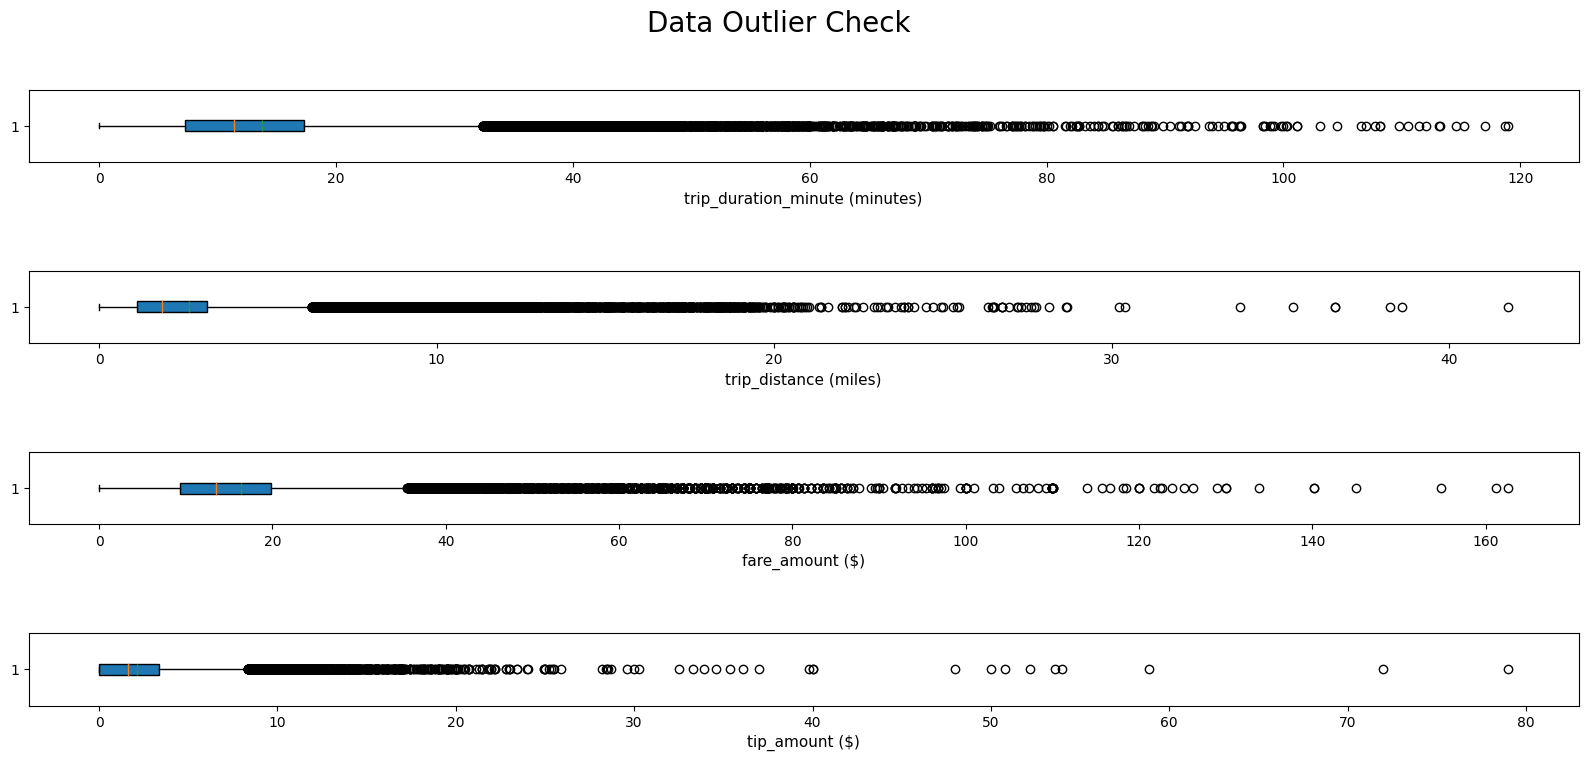

In [182]:
# Check kembali pesebaran data

fig, axes = plt.subplots(4, 1, figsize=(20, 8))
axes[0].boxplot(df.trip_duration_minute, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[1].boxplot(df.trip_distance, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[2].boxplot(df.fare_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[3].boxplot(df.tip_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)

axes[0].set_xlabel("trip_duration_minute (minutes)", fontsize=11)
axes[1].set_xlabel("trip_distance (miles)", fontsize=11)
axes[2].set_xlabel("fare_amount ($)", fontsize=11)
axes[3].set_xlabel("tip_amount ($)", fontsize=11)

fig.suptitle("Data Outlier Check", fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, wspace=1.5, hspace=1.5)
plt.show()

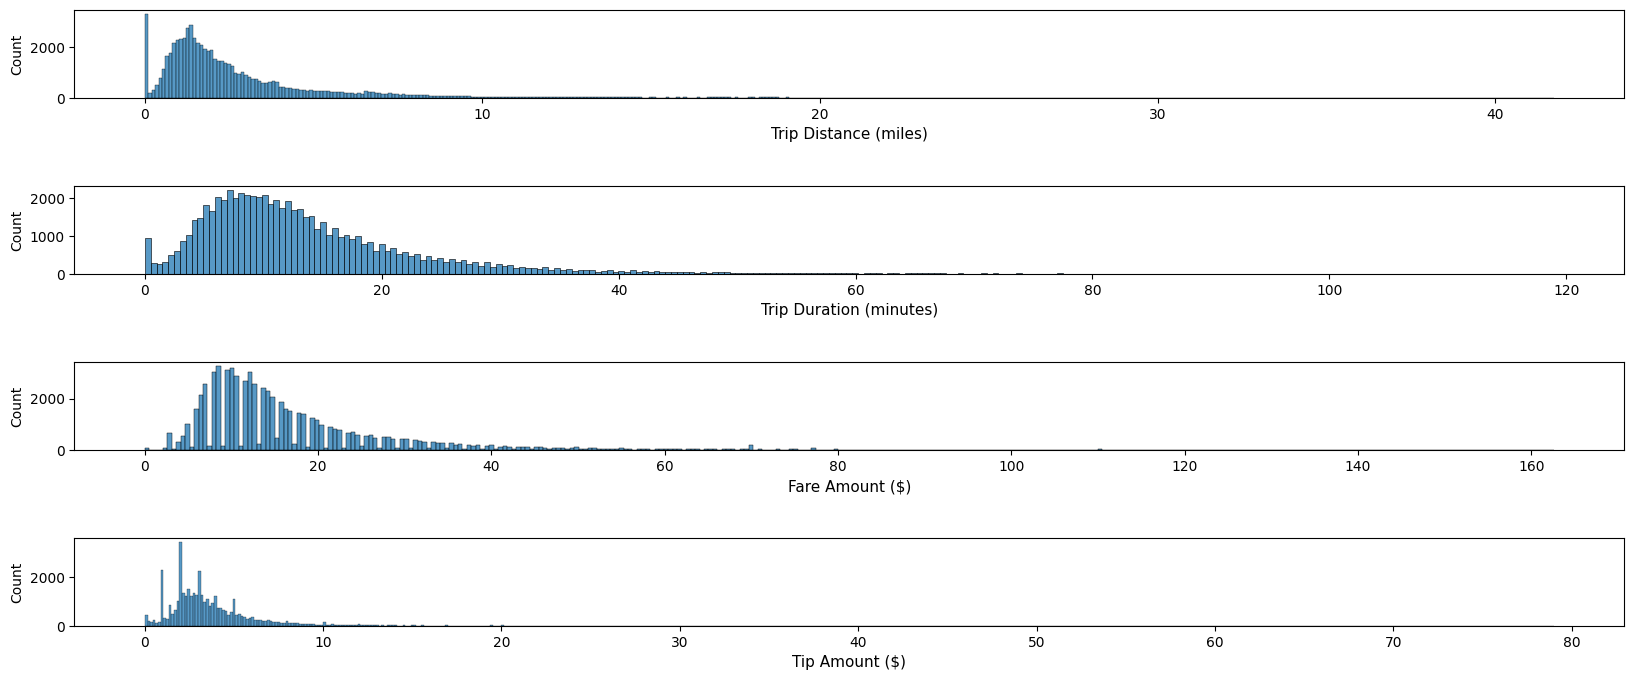

In [183]:
fig, axes = plt.subplots(4, 1, figsize=(20, 8))
sns.histplot(df.trip_distance, ax=axes[0])
sns.histplot(df.trip_duration_minute, ax=axes[1])
sns.histplot(df.fare_amount, ax=axes[2])
sns.histplot(df[df.tip_amount > 0].tip_amount, ax=axes[3])

axes[0].set_xlabel("Trip Distance (miles)", fontsize=11)
axes[1].set_xlabel("Trip Duration (minutes)", fontsize=11)
axes[2].set_xlabel("Fare Amount ($)", fontsize=11)
axes[3].set_xlabel("Tip Amount ($)", fontsize=11)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=1)
plt.show()

Meskipun dari grafik diatas masih terdapat data outlier, namun data tersebut masih diperlukan untuk menganalisa berikutnya

Sebelumnya kita sudah melakukan imputasi untuk kolom "trip_distance", "trip_duration_minute", "fare_amount". Kemudian selanjutnya kita akan menghitung ulang kolom "lpep_dropoff_datetime", "avg_speed_MPH" dan "total_amount".

In [184]:
# Update kolom

# update kolom lpep_dropoff_datetime
df.lpep_dropoff_datetime = (df.lpep_pickup_datetime + df.trip_duration_minute.apply(lambda x: timedelta(seconds=x))).astype('datetime64[s]')

# update kolom avg_speed_MPH
df.avg_speed_MPH = (df.trip_distance / (df.trip_duration_minute / 60)).round(2)

# update kolom avg_speed_MPH
df.total_amount = df.fare_amount + df.extra + df.mta_tax + df.tip_amount + df.tolls_amount + df.improvement_surcharge + df.congestion_surcharge

In [185]:
# Cek data yang masih anomali

df[(df.trip_distance <= 0.2) & (df.trip_duration_minute <= 1) & (df.avg_speed_MPH > 10)]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong
161,2,2023-01-01 01:59:48,2023-01-01 01:59:48,0.05,0.09,108.00,5.0,36,36,2.0,100.0,0.0,0.0,20.06,0.0,0.3,0.0,120.36,1.0,2.0,Brooklyn,Brooklyn,Bushwick North,Bushwick North,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.000000
209,2,2023-01-01 03:11:03,2023-01-01 03:11:03,0.10,0.04,24.00,5.0,61,61,2.0,30.0,0.0,0.0,1.00,0.0,0.3,0.0,31.30,1.0,2.0,Brooklyn,Brooklyn,Crown Heights North,Crown Heights North,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.010870
210,2,2023-01-01 03:28:59,2023-01-01 03:28:59,0.08,0.12,90.00,5.0,33,33,1.0,30.0,0.0,0.0,6.06,0.0,0.3,0.0,36.36,1.0,2.0,Brooklyn,Brooklyn,Brooklyn Heights,Brooklyn Heights,Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.043137
216,2,2023-01-01 03:11:11,2023-01-01 03:11:11,0.07,0.02,17.14,5.0,256,256,1.0,35.0,0.0,0.0,0.00,0.0,0.3,0.0,35.30,1.0,2.0,Brooklyn,Brooklyn,Williamsburg (South Side),Williamsburg (South Side),Boro Zone,Boro Zone,2504700,2504700.0,41710.864865,41710.864865,0.055944
651,2,2023-01-01 14:58:13,2023-01-01 14:58:13,0.43,0.17,23.72,1.0,75,74,2.0,3.0,0.0,0.5,0.00,0.0,1.0,0.0,4.50,3.0,1.0,Manhattan,Manhattan,East Harlem South,East Harlem North,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273,0.004853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62601,1,2023-01-31 18:07:39,2023-01-31 18:07:39,0.27,0.10,22.22,1.0,260,260,1.0,3.0,2.5,1.5,0.00,0.0,1.0,0.0,8.00,2.0,1.0,Queens,Queens,Woodside,Woodside,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.003630
62608,2,2023-01-31 18:11:33,2023-01-31 18:11:33,0.42,0.16,22.86,1.0,74,42,1.0,3.0,2.5,0.5,0.00,0.0,1.0,0.0,7.00,2.0,1.0,Manhattan,Manhattan,East Harlem North,Central Harlem North,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273,0.004450
62672,2,2023-01-31 18:39:16,2023-01-31 18:39:16,0.22,0.05,13.64,1.0,130,130,3.0,3.0,2.5,0.5,0.00,0.0,1.0,0.0,7.00,4.0,1.0,Queens,Queens,Jamaica,Jamaica,Boro Zone,Boro Zone,2233270,2233270.0,26896.305085,26896.305085,0.000000
62858,2,2023-01-31 19:06:18,2023-01-31 19:06:18,0.47,0.08,10.21,1.0,75,75,2.0,3.0,2.5,0.5,0.00,0.0,1.0,0.0,7.00,3.0,1.0,Manhattan,Manhattan,East Harlem South,East Harlem South,Boro Zone,Boro Zone,1575590,1575590.0,75492.477273,75492.477273,0.014641


Setelah imputasi dilakukan dan kita cek kembali data anomali, masih terdapat data yang tidak masuk akal seperti tabel diatas. Kita dapat membuang data tersebut, karena data tersebut tidak dapat dilakukan analisa, dan jumlah data anomali yang tersisa hanya 158 baris dari 67306 baris (0.002%)

In [186]:
# drop sisa data outlier

index_drop = df[(df.trip_distance <= 0.2) & (df.trip_duration_minute <= 1) & (df.avg_speed_MPH > 10)].index
df.drop(index_drop, inplace=True)

In [187]:
# Cek kembali data yang masih anomali

df[(df.trip_distance <= 0.2) & (df.trip_duration_minute <= 1) & (df.avg_speed_MPH > 10)]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,trip_duration_minute,trip_distance,avg_speed_MPH,RatecodeID,PULocationID,DOLocationID,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,payment_type,trip_type,PU_Borough,DO_Borough,PU_Zone,DO_Zone,PU_Service_Zone,DO_Service_Zone,PU_population,DO_population,PU_density,DO_density,p_cong


## 5. Final Check Data
(n=67148)

In [188]:
checkData(df)

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,VendorID,object,67148,0,0.000000,2,"[2, 1]"
1,lpep_pickup_datetime,datetime64[s],67148,0,0.000000,65735,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
2,lpep_dropoff_datetime,datetime64[s],67148,0,0.000000,65973,"[2023-01-01 00:26:21, 2023-01-01 00:51:09, 202..."
3,trip_duration_minute,float64,67148,0,0.000000,3594,"[11.02, 6.77, 6.33, 5.82, 5.97, 17.55, 17.42, ..."
4,trip_distance,float64,67148,0,0.000000,1799,"[2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1..."
5,avg_speed_MPH,float64,67148,6,0.008935,3489,"[14.05, 16.04, 0.0, 13.4, 11.06, 9.5, 13.09, 8..."
6,RatecodeID,object,67148,0,0.000000,4,"[1.0, 5.0, 2.0, 3.0]"
7,PULocationID,object,67148,0,0.000000,222,"[166, 24, 223, 41, 181, 255, 75, 66, 195, 83, ..."
8,DOLocationID,object,67148,0,0.000000,246,"[143, 43, 179, 238, 74, 262, 45, 75, 166, 140,..."
9,passenger_count,object,67148,0,0.000000,6,"[1.0, 2.0, 4.0, 3.0, 6.0, 5.0]"


**Insight:**
1. Drop kolom "VendorID", "PULocationID", "DOLocationID", "p_cong", "PU_Service_Zone", "DO_Service_Zone"
2. Cek kolom "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", dan "total_amount" (round 2 angka dibelakang koma)
3. Cek kolom "DO_population" menjadi tipe data int64
4. Cek kolom "RatecodeID", "passenger_count", "payment_type", "trip_type" (hilangkan angka desimal)
5. Ubah nama kolom "lpep_pickup_datetime" dan "lpep_dropoff_datetime" menjadi "pickup_datetime" dan "dropoff_datetime" agar lebih ringkes

In [189]:
# 1. Drop kolom

df.drop(columns=["VendorID", "PULocationID", "DOLocationID", "p_cong", "PU_Service_Zone", "DO_Service_Zone"], inplace=True)

In [190]:
# 2. Round 2 angka dibelakang koma

df[["fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "total_amount"]] = \
    df[["fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "total_amount"]].round(2)

In [191]:
# 3. Ubah tipe data

df["DO_population"] = df["DO_population"].astype("Int64")

In [192]:
# 4. Drop angka desimal pada kolom "RatecodeID", "passenger_count", "payment_type", "trip_type"

df[["RatecodeID", "passenger_count", "payment_type", "trip_type"]] = df[["RatecodeID", "passenger_count", "payment_type", "trip_type"]].replace(".0", "", regex=True)

In [193]:
# 5. Ubah nama kolom

df.rename(columns={
    'lpep_pickup_datetime': 'pickup_datetime',
    'lpep_dropoff_datetime': 'dropoff_datetime',
}, inplace=True)

Selanjutnya kita akan simpan dataset yang sudah dilakukan cleansing menjadi file .csv agar bisa dilakukan data analysis

In [194]:
checkData(df)

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,pickup_datetime,datetime64[s],67148,0,0.000000,65735,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 202..."
1,dropoff_datetime,datetime64[s],67148,0,0.000000,65973,"[2023-01-01 00:26:21, 2023-01-01 00:51:09, 202..."
2,trip_duration_minute,float64,67148,0,0.000000,3594,"[11.02, 6.77, 6.33, 5.82, 5.97, 17.55, 17.42, ..."
3,trip_distance,float64,67148,0,0.000000,1799,"[2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1..."
4,avg_speed_MPH,float64,67148,6,0.008935,3489,"[14.05, 16.04, 0.0, 13.4, 11.06, 9.5, 13.09, 8..."
5,RatecodeID,object,67148,0,0.000000,4,"[1, 5, 2, 3]"
6,passenger_count,object,67148,0,0.000000,6,"[1, 2, 4, 3, 6, 5]"
7,fare_amount,float64,67148,0,0.000000,2470,"[14.9, 10.7, 7.2, 6.5, 6.0, 17.7, 19.1, 14.2, ..."
8,extra,float64,67148,0,0.000000,12,"[1.0, 0.5, 3.75, 0.0, 3.25, 6.0, 5.0, 2.75, 5...."
9,mta_tax,float64,67148,0,0.000000,5,"[0.5, 1.5, 0.0, 1.0, 2.75]"


In [195]:
# Simpan file to csv

df = df.to_csv(r"D:\\Purwadhika JCDS\\Capstone Project\\Modul-2\data\\processed\data_clean.csv", index = None, header=True)